In [17]:
MAX_ROUNDS = 300
OPTIMIZE_ROUNDS = False
LEARNING_RATE = 0.07
EARLY_STOPPING_ROUNDS = 50  
# Note: I set EARLY_STOPPING_ROUNDS high so that (when OPTIMIZE_ROUNDS is set)
#       I will get lots of information to make my own judgment.  You should probably
#       reduce EARLY_STOPPING_ROUNDS if you want to do actual early stopping.
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from numba import jit
import time
import gc
import lightgbm as lgb

if __name__ == '__main__':
    # Compute gini
    # from CPMP's kernel https://www.kaggle.com/cpmpml/extremely-fast-gini-computation
    @jit
    def eval_gini(y_true, y_prob):
        y_true = np.asarray(y_true)
        y_true = y_true[np.argsort(y_prob)]
        ntrue = 0
        gini = 0
        delta = 0
        n = len(y_true)
        for i in range(n-1, -1, -1):
            y_i = y_true[i]
            ntrue += y_i
            gini += y_i * delta
            delta += 1 - y_i
        gini = 1 - 2 * gini / (ntrue * (n - ntrue))
        return gini

    # Funcitons from olivier's kernel
    # https://www.kaggle.com/ogrellier/xgb-classifier-upsampling-lb-0-283

    def gini_xgb(preds, dtrain):
        labels = dtrain.get_label()
        gini_score = -eval_gini(labels, preds)
        return [('gini', gini_score)]

    def gini_lgb(preds, dtrain):
        y = list(dtrain.get_label())
        score = eval_gini(y, preds)
        return 'gini', score, True

    def add_noise(series, noise_level):
        return series * (1 + noise_level * np.random.randn(len(series)))


    def target_encode(trn_series=None,    # Revised to encode validation series
                      val_series=None,
                      tst_series=None,
                      target=None,
                      min_samples_leaf=1,
                      smoothing=1,
                      noise_level=0):
        """
        Smoothing is computed like in the following paper by Daniele Micci-Barreca
        https://kaggle2.blob.core.windows.net/forum-message-attachments/225952/7441/high%20cardinality%20categoricals.pdf
        trn_series : training categorical feature as a pd.Series
        tst_series : test categorical feature as a pd.Series
        target : target data as a pd.Series
        min_samples_leaf (int) : minimum samples to take category average into account
        smoothing (int) : smoothing effect to balance categorical average vs prior
        """
        assert len(trn_series) == len(target)
        assert trn_series.name == tst_series.name
        temp = pd.concat([trn_series, target], axis=1)
        # Compute target mean
        averages = temp.groupby(by=trn_series.name)[target.name].agg(["mean", "count"])
        # Compute smoothing
        smoothing = 1 / (1 + np.exp(-(averages["count"] - min_samples_leaf) / smoothing))
        # Apply average function to all target data
        prior = target.mean()
        # The bigger the count the less full_avg is taken into account
        averages[target.name] = prior * (1 - smoothing) + averages["mean"] * smoothing
        averages.drop(["mean", "count"], axis=1, inplace=True)
        # Apply averages to trn and tst series
        ft_trn_series = pd.merge(
            trn_series.to_frame(trn_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=trn_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_trn_series.index = trn_series.index
        ft_val_series = pd.merge(
            val_series.to_frame(val_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=val_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_val_series.index = val_series.index
        ft_tst_series = pd.merge(
            tst_series.to_frame(tst_series.name),
            averages.reset_index().rename(columns={'index': target.name, target.name: 'average'}),
            on=tst_series.name,
            how='left')['average'].rename(trn_series.name + '_mean').fillna(prior)
        # pd.merge does not keep the index so restore it
        ft_tst_series.index = tst_series.index
        return add_noise(ft_trn_series, noise_level), add_noise(ft_val_series, noise_level), add_noise(ft_tst_series, noise_level)

    # Read data
    train_df = pd.read_csv('D:/Driver/train.csv', na_values="-1") # .iloc[0:200,:]
    test_df = pd.read_csv('D:/Driver/test.csv', na_values="-1")
    sub = pd.DataFrame()
    sub['id'] = test_df['id']
    sub['target'] = 0

    # from olivier
    train_features = [
        "ps_car_13",  #            : 1571.65 / shadow  609.23
        "ps_reg_03",  #            : 1408.42 / shadow  511.15
        "ps_ind_05_cat",  #        : 1387.87 / shadow   84.72
        "ps_ind_03",  #            : 1219.47 / shadow  230.55
        "ps_ind_15",  #            :  922.18 / shadow  242.00
        "ps_reg_02",  #            :  920.65 / shadow  267.50
        "ps_car_14",  #            :  798.48 / shadow  549.58
        "ps_car_12",  #            :  731.93 / shadow  293.62
        "ps_car_01_cat",  #        :  698.07 / shadow  178.72
        "ps_car_07_cat",  #        :  694.53 / shadow   36.35
        "ps_ind_17_bin",  #        :  620.77 / shadow   23.15
        "ps_car_03_cat",  #        :  611.73 / shadow   50.67
        "ps_reg_01",  #            :  598.60 / shadow  178.57
        "ps_car_15",  #            :  593.35 / shadow  226.43
        "ps_ind_01",  #            :  547.32 / shadow  154.58
        "ps_ind_16_bin",  #        :  475.37 / shadow   34.17
        "ps_ind_07_bin",  #        :  435.28 / shadow   28.92
        "ps_car_06_cat",  #        :  398.02 / shadow  212.43
        "ps_car_04_cat",  #        :  376.87 / shadow   76.98
        "ps_ind_06_bin",  #        :  370.97 / shadow   36.13
        "ps_car_09_cat",  #        :  214.12 / shadow   81.38
        "ps_car_02_cat",  #        :  203.03 / shadow   26.67
        "ps_ind_02_cat",  #        :  189.47 / shadow   65.68
        "ps_car_11",  #            :  173.28 / shadow   76.45
        "ps_car_05_cat",  #        :  172.75 / shadow   62.92
        "ps_calc_09",  #           :  169.13 / shadow  129.72
        "ps_calc_05",  #           :  148.83 / shadow  120.68
        "ps_ind_08_bin",  #        :  140.73 / shadow   27.63
        "ps_car_08_cat",  #        :  120.87 / shadow   28.82
        "ps_ind_09_bin",  #        :  113.92 / shadow   27.05
        "ps_ind_04_cat",  #        :  107.27 / shadow   37.43
        "ps_ind_18_bin",  #        :   77.42 / shadow   25.97
        "ps_ind_12_bin",  #        :   39.67 / shadow   15.52
        "ps_ind_14",  #            :   37.37 / shadow   16.65
    ]
    # add combinations
    combs = [
        ('ps_reg_01', 'ps_car_02_cat'),
        ('ps_reg_01', 'ps_car_04_cat'),
    ]

    # Process data
    id_test = test_df['id'].values
    id_train = train_df['id'].values
    y = train_df['target']

    start = time.time()
    for n_c, (f1, f2) in enumerate(combs):
        name1 = f1 + "_plus_" + f2
        train_df[name1] = train_df[f1].apply(lambda x: str(x)) + "_" + train_df[f2].apply(lambda x: str(x))
        test_df[name1] = test_df[f1].apply(lambda x: str(x)) + "_" + test_df[f2].apply(lambda x: str(x))
        # Label Encode
        lbl = LabelEncoder()
        lbl.fit(list(train_df[name1].values) + list(test_df[name1].values))
        train_df[name1] = lbl.transform(list(train_df[name1].values))
        test_df[name1] = lbl.transform(list(test_df[name1].values))

        train_features.append(name1)

    X = train_df[train_features]
    test_df = test_df[train_features]

    f_cats = [f for f in X.columns if "_cat" in f]

    y_valid_pred = 0*y
    y_test_pred = 0

    # Set up folds
    K = 5
    kf = KFold(n_splits = K, random_state = 1, shuffle = True)
    np.random.seed(0)
    
    y_test_pred = 0
    # Set up classifier
    model = lgb.LGBMClassifier( n_estimators=2000,
                                max_depth=10,
                                objective="binary",
                                learning_rate=0.01,
                                subsample=0.9,
                                colsample_bytree=0.8,
                                max_bin=10,
                                subsample_freq=10,
                                min_child_samples=500,
                            )

    for i, (train_index, test_index) in enumerate(kf.split(train_df)):
        # Create data for this fold
        y_train, y_valid = y.iloc[train_index].copy(), y.iloc[test_index]
        X_train, X_valid = X.iloc[train_index, :].copy(), X.iloc[test_index, :].copy()
        X_test = test_df.copy()
        print("\nFold ", i)

        # Enocode data
        for f in f_cats:
            X_train[f + "_avg"], X_valid[f + "_avg"], X_test[f + "_avg"] = target_encode(
                trn_series=X_train[f],
                val_series=X_valid[f],
                tst_series=X_test[f],
                target=y_train,
                min_samples_leaf=200,
                smoothing=10,
                noise_level=0
            )
        # Run model for this fold
        eval_set = [(X_valid, y_valid)]
        fit_model = model.fit(X_train, y_train,
                              eval_set=eval_set,
                              eval_metric = 'auc',
                              early_stopping_rounds=100,
                              verbose=True
                              )
        print("  Best N trees = ", model.best_iteration_)
        print("  Best gini = ", model.best_score_)

        # Generate validation predictions for this fold
        pred = fit_model.predict_proba(X_valid)[:, 1]
        print("  Gini = ", eval_gini(y_valid, pred))
        y_valid_pred.iloc[test_index] = pred

        # Accumulate test set predictions
        y_test_pred += fit_model.predict_proba(X_test)[:, 1]

        del X_test, X_train, X_valid, y_train

    y_test_pred /= K  # Average test set predictions
    sub['target'] += y_test_pred

    print("\nGini for full training set:")
    eval_gini(y, y_valid_pred)   
    sub.to_csv('andy.csv',index=False)

('\nFold ', 0)
[1]	valid_0's auc: 0.609524
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.620091
[3]	valid_0's auc: 0.621097
[4]	valid_0's auc: 0.622027
[5]	valid_0's auc: 0.622128
[6]	valid_0's auc: 0.624335
[7]	valid_0's auc: 0.624116
[8]	valid_0's auc: 0.623751
[9]	valid_0's auc: 0.623772
[10]	valid_0's auc: 0.624218
[11]	valid_0's auc: 0.624924
[12]	valid_0's auc: 0.625014
[13]	valid_0's auc: 0.625328
[14]	valid_0's auc: 0.625768
[15]	valid_0's auc: 0.626015
[16]	valid_0's auc: 0.625953
[17]	valid_0's auc: 0.626231
[18]	valid_0's auc: 0.626033
[19]	valid_0's auc: 0.62595
[20]	valid_0's auc: 0.625654
[21]	valid_0's auc: 0.625542
[22]	valid_0's auc: 0.625755
[23]	valid_0's auc: 0.626164
[24]	valid_0's auc: 0.626538
[25]	valid_0's auc: 0.626444
[26]	valid_0's auc: 0.626622
[27]	valid_0's auc: 0.626712
[28]	valid_0's auc: 0.626722
[29]	valid_0's auc: 0.626875
[30]	valid_0's auc: 0.626673
[31]	valid_0's auc: 0.626725
[32]	valid_0's auc: 0.626629
[33]

[279]	valid_0's auc: 0.631486
[280]	valid_0's auc: 0.631551
[281]	valid_0's auc: 0.631637
[282]	valid_0's auc: 0.631736
[283]	valid_0's auc: 0.631814
[284]	valid_0's auc: 0.631869
[285]	valid_0's auc: 0.631919
[286]	valid_0's auc: 0.631994
[287]	valid_0's auc: 0.632071
[288]	valid_0's auc: 0.632135
[289]	valid_0's auc: 0.632184
[290]	valid_0's auc: 0.632256
[291]	valid_0's auc: 0.632244
[292]	valid_0's auc: 0.63228
[293]	valid_0's auc: 0.632356
[294]	valid_0's auc: 0.632398
[295]	valid_0's auc: 0.632383
[296]	valid_0's auc: 0.63248
[297]	valid_0's auc: 0.632468
[298]	valid_0's auc: 0.632506
[299]	valid_0's auc: 0.6325
[300]	valid_0's auc: 0.632522
[301]	valid_0's auc: 0.632528
[302]	valid_0's auc: 0.632563
[303]	valid_0's auc: 0.632578
[304]	valid_0's auc: 0.632576
[305]	valid_0's auc: 0.63259
[306]	valid_0's auc: 0.632549
[307]	valid_0's auc: 0.632541
[308]	valid_0's auc: 0.632551
[309]	valid_0's auc: 0.632583
[310]	valid_0's auc: 0.632597
[311]	valid_0's auc: 0.632644
[312]	valid_0's

[555]	valid_0's auc: 0.640432
[556]	valid_0's auc: 0.640461
[557]	valid_0's auc: 0.640485
[558]	valid_0's auc: 0.640503
[559]	valid_0's auc: 0.640532
[560]	valid_0's auc: 0.640544
[561]	valid_0's auc: 0.640559
[562]	valid_0's auc: 0.640589
[563]	valid_0's auc: 0.640608
[564]	valid_0's auc: 0.640633
[565]	valid_0's auc: 0.640662
[566]	valid_0's auc: 0.640694
[567]	valid_0's auc: 0.64072
[568]	valid_0's auc: 0.640754
[569]	valid_0's auc: 0.640775
[570]	valid_0's auc: 0.640801
[571]	valid_0's auc: 0.640866
[572]	valid_0's auc: 0.64088
[573]	valid_0's auc: 0.640904
[574]	valid_0's auc: 0.640911
[575]	valid_0's auc: 0.640928
[576]	valid_0's auc: 0.640931
[577]	valid_0's auc: 0.640978
[578]	valid_0's auc: 0.641
[579]	valid_0's auc: 0.641004
[580]	valid_0's auc: 0.640994
[581]	valid_0's auc: 0.641004
[582]	valid_0's auc: 0.641045
[583]	valid_0's auc: 0.64107
[584]	valid_0's auc: 0.641102
[585]	valid_0's auc: 0.641131
[586]	valid_0's auc: 0.641153
[587]	valid_0's auc: 0.641174
[588]	valid_0's 

[834]	valid_0's auc: 0.64315
[835]	valid_0's auc: 0.64316
[836]	valid_0's auc: 0.643173
[837]	valid_0's auc: 0.643166
[838]	valid_0's auc: 0.643165
[839]	valid_0's auc: 0.643162
[840]	valid_0's auc: 0.64317
[841]	valid_0's auc: 0.643173
[842]	valid_0's auc: 0.643176
[843]	valid_0's auc: 0.643212
[844]	valid_0's auc: 0.643234
[845]	valid_0's auc: 0.643246
[846]	valid_0's auc: 0.643267
[847]	valid_0's auc: 0.64327
[848]	valid_0's auc: 0.643288
[849]	valid_0's auc: 0.64329
[850]	valid_0's auc: 0.6433
[851]	valid_0's auc: 0.643299
[852]	valid_0's auc: 0.64331
[853]	valid_0's auc: 0.643294
[854]	valid_0's auc: 0.643321
[855]	valid_0's auc: 0.643329
[856]	valid_0's auc: 0.643321
[857]	valid_0's auc: 0.643339
[858]	valid_0's auc: 0.643329
[859]	valid_0's auc: 0.643349
[860]	valid_0's auc: 0.643349
[861]	valid_0's auc: 0.643353
[862]	valid_0's auc: 0.643354
[863]	valid_0's auc: 0.643363
[864]	valid_0's auc: 0.643376
[865]	valid_0's auc: 0.643387
[866]	valid_0's auc: 0.643387
[867]	valid_0's au

[1105]	valid_0's auc: 0.643715
[1106]	valid_0's auc: 0.643722
[1107]	valid_0's auc: 0.643733
[1108]	valid_0's auc: 0.643736
[1109]	valid_0's auc: 0.643747
[1110]	valid_0's auc: 0.643749
[1111]	valid_0's auc: 0.643742
[1112]	valid_0's auc: 0.643743
[1113]	valid_0's auc: 0.643745
[1114]	valid_0's auc: 0.643746
[1115]	valid_0's auc: 0.643743
[1116]	valid_0's auc: 0.643728
[1117]	valid_0's auc: 0.643722
[1118]	valid_0's auc: 0.643721
[1119]	valid_0's auc: 0.643711
[1120]	valid_0's auc: 0.64371
[1121]	valid_0's auc: 0.643711
[1122]	valid_0's auc: 0.643742
[1123]	valid_0's auc: 0.643739
[1124]	valid_0's auc: 0.643756
[1125]	valid_0's auc: 0.643753
[1126]	valid_0's auc: 0.643749
[1127]	valid_0's auc: 0.643754
[1128]	valid_0's auc: 0.643753
[1129]	valid_0's auc: 0.64375
[1130]	valid_0's auc: 0.643758
[1131]	valid_0's auc: 0.643755
[1132]	valid_0's auc: 0.643749
[1133]	valid_0's auc: 0.643755
[1134]	valid_0's auc: 0.643757
[1135]	valid_0's auc: 0.643742
[1136]	valid_0's auc: 0.643744
[1137]	val

[1373]	valid_0's auc: 0.643915
[1374]	valid_0's auc: 0.643917
[1375]	valid_0's auc: 0.643913
[1376]	valid_0's auc: 0.643899
[1377]	valid_0's auc: 0.6439
[1378]	valid_0's auc: 0.643896
[1379]	valid_0's auc: 0.643879
[1380]	valid_0's auc: 0.643875
[1381]	valid_0's auc: 0.643857
[1382]	valid_0's auc: 0.643849
[1383]	valid_0's auc: 0.643835
[1384]	valid_0's auc: 0.643832
[1385]	valid_0's auc: 0.643817
[1386]	valid_0's auc: 0.643811
[1387]	valid_0's auc: 0.643815
[1388]	valid_0's auc: 0.643787
[1389]	valid_0's auc: 0.643795
[1390]	valid_0's auc: 0.643766
[1391]	valid_0's auc: 0.643758
[1392]	valid_0's auc: 0.643752
[1393]	valid_0's auc: 0.643742
[1394]	valid_0's auc: 0.643746
[1395]	valid_0's auc: 0.643753
[1396]	valid_0's auc: 0.643755
[1397]	valid_0's auc: 0.64375
[1398]	valid_0's auc: 0.643742
[1399]	valid_0's auc: 0.643735
[1400]	valid_0's auc: 0.643731
[1401]	valid_0's auc: 0.643734
[1402]	valid_0's auc: 0.643731
[1403]	valid_0's auc: 0.643742
[1404]	valid_0's auc: 0.643756
[1405]	vali

[196]	valid_0's auc: 0.62815
[197]	valid_0's auc: 0.628195
[198]	valid_0's auc: 0.628308
[199]	valid_0's auc: 0.628289
[200]	valid_0's auc: 0.628309
[201]	valid_0's auc: 0.628347
[202]	valid_0's auc: 0.62836
[203]	valid_0's auc: 0.62836
[204]	valid_0's auc: 0.628384
[205]	valid_0's auc: 0.628406
[206]	valid_0's auc: 0.628409
[207]	valid_0's auc: 0.628462
[208]	valid_0's auc: 0.628513
[209]	valid_0's auc: 0.628523
[210]	valid_0's auc: 0.628552
[211]	valid_0's auc: 0.628648
[212]	valid_0's auc: 0.628751
[213]	valid_0's auc: 0.628829
[214]	valid_0's auc: 0.628814
[215]	valid_0's auc: 0.628836
[216]	valid_0's auc: 0.628861
[217]	valid_0's auc: 0.628895
[218]	valid_0's auc: 0.628944
[219]	valid_0's auc: 0.62899
[220]	valid_0's auc: 0.629036
[221]	valid_0's auc: 0.62903
[222]	valid_0's auc: 0.629041
[223]	valid_0's auc: 0.629089
[224]	valid_0's auc: 0.629074
[225]	valid_0's auc: 0.629085
[226]	valid_0's auc: 0.629059
[227]	valid_0's auc: 0.629031
[228]	valid_0's auc: 0.629044
[229]	valid_0's

[471]	valid_0's auc: 0.636889
[472]	valid_0's auc: 0.636929
[473]	valid_0's auc: 0.636965
[474]	valid_0's auc: 0.63696
[475]	valid_0's auc: 0.636956
[476]	valid_0's auc: 0.636962
[477]	valid_0's auc: 0.636962
[478]	valid_0's auc: 0.636978
[479]	valid_0's auc: 0.637021
[480]	valid_0's auc: 0.63699
[481]	valid_0's auc: 0.637011
[482]	valid_0's auc: 0.637027
[483]	valid_0's auc: 0.637043
[484]	valid_0's auc: 0.637078
[485]	valid_0's auc: 0.637111
[486]	valid_0's auc: 0.637121
[487]	valid_0's auc: 0.637117
[488]	valid_0's auc: 0.637125
[489]	valid_0's auc: 0.63716
[490]	valid_0's auc: 0.637169
[491]	valid_0's auc: 0.637192
[492]	valid_0's auc: 0.637205
[493]	valid_0's auc: 0.637206
[494]	valid_0's auc: 0.637212
[495]	valid_0's auc: 0.637221
[496]	valid_0's auc: 0.637242
[497]	valid_0's auc: 0.637257
[498]	valid_0's auc: 0.637285
[499]	valid_0's auc: 0.637304
[500]	valid_0's auc: 0.637316
[501]	valid_0's auc: 0.637348
[502]	valid_0's auc: 0.637366
[503]	valid_0's auc: 0.637381
[504]	valid_0

[750]	valid_0's auc: 0.640177
[751]	valid_0's auc: 0.64018
[752]	valid_0's auc: 0.64016
[753]	valid_0's auc: 0.640162
[754]	valid_0's auc: 0.640139
[755]	valid_0's auc: 0.640129
[756]	valid_0's auc: 0.640108
[757]	valid_0's auc: 0.640093
[758]	valid_0's auc: 0.640111
[759]	valid_0's auc: 0.640117
[760]	valid_0's auc: 0.640094
[761]	valid_0's auc: 0.640121
[762]	valid_0's auc: 0.640138
[763]	valid_0's auc: 0.64016
[764]	valid_0's auc: 0.640174
[765]	valid_0's auc: 0.640184
[766]	valid_0's auc: 0.640202
[767]	valid_0's auc: 0.64021
[768]	valid_0's auc: 0.640214
[769]	valid_0's auc: 0.640232
[770]	valid_0's auc: 0.640238
[771]	valid_0's auc: 0.640266
[772]	valid_0's auc: 0.640301
[773]	valid_0's auc: 0.640315
[774]	valid_0's auc: 0.640318
[775]	valid_0's auc: 0.640345
[776]	valid_0's auc: 0.640371
[777]	valid_0's auc: 0.640386
[778]	valid_0's auc: 0.640397
[779]	valid_0's auc: 0.640409
[780]	valid_0's auc: 0.640422
[781]	valid_0's auc: 0.640428
[782]	valid_0's auc: 0.640449
[783]	valid_0'

[1024]	valid_0's auc: 0.64092
[1025]	valid_0's auc: 0.640922
[1026]	valid_0's auc: 0.640931
[1027]	valid_0's auc: 0.640927
[1028]	valid_0's auc: 0.640928
[1029]	valid_0's auc: 0.640929
[1030]	valid_0's auc: 0.640931
[1031]	valid_0's auc: 0.64092
[1032]	valid_0's auc: 0.640921
[1033]	valid_0's auc: 0.640923
[1034]	valid_0's auc: 0.640931
[1035]	valid_0's auc: 0.640936
[1036]	valid_0's auc: 0.640935
[1037]	valid_0's auc: 0.640935
[1038]	valid_0's auc: 0.640932
[1039]	valid_0's auc: 0.640935
[1040]	valid_0's auc: 0.640942
[1041]	valid_0's auc: 0.640963
[1042]	valid_0's auc: 0.640962
[1043]	valid_0's auc: 0.640975
[1044]	valid_0's auc: 0.640976
[1045]	valid_0's auc: 0.640983
[1046]	valid_0's auc: 0.640983
[1047]	valid_0's auc: 0.641004
[1048]	valid_0's auc: 0.641005
[1049]	valid_0's auc: 0.641012
[1050]	valid_0's auc: 0.64102
[1051]	valid_0's auc: 0.641016
[1052]	valid_0's auc: 0.641011
[1053]	valid_0's auc: 0.641017
[1054]	valid_0's auc: 0.641034
[1055]	valid_0's auc: 0.641045
[1056]	vali

[15]	valid_0's auc: 0.616164
[16]	valid_0's auc: 0.616014
[17]	valid_0's auc: 0.616083
[18]	valid_0's auc: 0.616218
[19]	valid_0's auc: 0.616223
[20]	valid_0's auc: 0.616122
[21]	valid_0's auc: 0.615995
[22]	valid_0's auc: 0.616167
[23]	valid_0's auc: 0.616518
[24]	valid_0's auc: 0.616957
[25]	valid_0's auc: 0.617054
[26]	valid_0's auc: 0.617117
[27]	valid_0's auc: 0.617267
[28]	valid_0's auc: 0.617298
[29]	valid_0's auc: 0.617397
[30]	valid_0's auc: 0.617435
[31]	valid_0's auc: 0.617604
[32]	valid_0's auc: 0.617512
[33]	valid_0's auc: 0.617573
[34]	valid_0's auc: 0.617425
[35]	valid_0's auc: 0.617499
[36]	valid_0's auc: 0.617489
[37]	valid_0's auc: 0.617694
[38]	valid_0's auc: 0.617707
[39]	valid_0's auc: 0.61764
[40]	valid_0's auc: 0.617526
[41]	valid_0's auc: 0.617694
[42]	valid_0's auc: 0.617972
[43]	valid_0's auc: 0.618031
[44]	valid_0's auc: 0.618087
[45]	valid_0's auc: 0.618017
[46]	valid_0's auc: 0.618032
[47]	valid_0's auc: 0.617973
[48]	valid_0's auc: 0.618029
[49]	valid_0's 

[294]	valid_0's auc: 0.624467
[295]	valid_0's auc: 0.62452
[296]	valid_0's auc: 0.624643
[297]	valid_0's auc: 0.624702
[298]	valid_0's auc: 0.624771
[299]	valid_0's auc: 0.624849
[300]	valid_0's auc: 0.62486
[301]	valid_0's auc: 0.625007
[302]	valid_0's auc: 0.624987
[303]	valid_0's auc: 0.625034
[304]	valid_0's auc: 0.625184
[305]	valid_0's auc: 0.625233
[306]	valid_0's auc: 0.625354
[307]	valid_0's auc: 0.625489
[308]	valid_0's auc: 0.6255
[309]	valid_0's auc: 0.625544
[310]	valid_0's auc: 0.62561
[311]	valid_0's auc: 0.625634
[312]	valid_0's auc: 0.625741
[313]	valid_0's auc: 0.625829
[314]	valid_0's auc: 0.625888
[315]	valid_0's auc: 0.625905
[316]	valid_0's auc: 0.625907
[317]	valid_0's auc: 0.625983
[318]	valid_0's auc: 0.626068
[319]	valid_0's auc: 0.626117
[320]	valid_0's auc: 0.626145
[321]	valid_0's auc: 0.626156
[322]	valid_0's auc: 0.626196
[323]	valid_0's auc: 0.626269
[324]	valid_0's auc: 0.626265
[325]	valid_0's auc: 0.626342
[326]	valid_0's auc: 0.626351
[327]	valid_0's

[571]	valid_0's auc: 0.632927
[572]	valid_0's auc: 0.632968
[573]	valid_0's auc: 0.633018
[574]	valid_0's auc: 0.633045
[575]	valid_0's auc: 0.633098
[576]	valid_0's auc: 0.633089
[577]	valid_0's auc: 0.633144
[578]	valid_0's auc: 0.633188
[579]	valid_0's auc: 0.633241
[580]	valid_0's auc: 0.633258
[581]	valid_0's auc: 0.633312
[582]	valid_0's auc: 0.633355
[583]	valid_0's auc: 0.633406
[584]	valid_0's auc: 0.633461
[585]	valid_0's auc: 0.633524
[586]	valid_0's auc: 0.63355
[587]	valid_0's auc: 0.633592
[588]	valid_0's auc: 0.633627
[589]	valid_0's auc: 0.63365
[590]	valid_0's auc: 0.633704
[591]	valid_0's auc: 0.633712
[592]	valid_0's auc: 0.633734
[593]	valid_0's auc: 0.633747
[594]	valid_0's auc: 0.633741
[595]	valid_0's auc: 0.633752
[596]	valid_0's auc: 0.633763
[597]	valid_0's auc: 0.633764
[598]	valid_0's auc: 0.633754
[599]	valid_0's auc: 0.633735
[600]	valid_0's auc: 0.633742
[601]	valid_0's auc: 0.633734
[602]	valid_0's auc: 0.633744
[603]	valid_0's auc: 0.633762
[604]	valid_

[847]	valid_0's auc: 0.636285
[848]	valid_0's auc: 0.636298
[849]	valid_0's auc: 0.636318
[850]	valid_0's auc: 0.636326
[851]	valid_0's auc: 0.636311
[852]	valid_0's auc: 0.636303
[853]	valid_0's auc: 0.636316
[854]	valid_0's auc: 0.636302
[855]	valid_0's auc: 0.636282
[856]	valid_0's auc: 0.636268
[857]	valid_0's auc: 0.636272
[858]	valid_0's auc: 0.636266
[859]	valid_0's auc: 0.636274
[860]	valid_0's auc: 0.636298
[861]	valid_0's auc: 0.636313
[862]	valid_0's auc: 0.636323
[863]	valid_0's auc: 0.636332
[864]	valid_0's auc: 0.636355
[865]	valid_0's auc: 0.63635
[866]	valid_0's auc: 0.636361
[867]	valid_0's auc: 0.636373
[868]	valid_0's auc: 0.636385
[869]	valid_0's auc: 0.636394
[870]	valid_0's auc: 0.636416
[871]	valid_0's auc: 0.636427
[872]	valid_0's auc: 0.636414
[873]	valid_0's auc: 0.636409
[874]	valid_0's auc: 0.636416
[875]	valid_0's auc: 0.636406
[876]	valid_0's auc: 0.636401
[877]	valid_0's auc: 0.636406
[878]	valid_0's auc: 0.636396
[879]	valid_0's auc: 0.636393
[880]	valid

[1122]	valid_0's auc: 0.63686
[1123]	valid_0's auc: 0.636857
[1124]	valid_0's auc: 0.636856
[1125]	valid_0's auc: 0.636867
[1126]	valid_0's auc: 0.636891
[1127]	valid_0's auc: 0.636918
[1128]	valid_0's auc: 0.636926
[1129]	valid_0's auc: 0.636921
[1130]	valid_0's auc: 0.636929
[1131]	valid_0's auc: 0.636935
[1132]	valid_0's auc: 0.636957
[1133]	valid_0's auc: 0.636969
[1134]	valid_0's auc: 0.636973
[1135]	valid_0's auc: 0.636988
[1136]	valid_0's auc: 0.636989
[1137]	valid_0's auc: 0.636986
[1138]	valid_0's auc: 0.636982
[1139]	valid_0's auc: 0.636979
[1140]	valid_0's auc: 0.636972
[1141]	valid_0's auc: 0.636986
[1142]	valid_0's auc: 0.636993
[1143]	valid_0's auc: 0.637003
[1144]	valid_0's auc: 0.637005
[1145]	valid_0's auc: 0.637012
[1146]	valid_0's auc: 0.637024
[1147]	valid_0's auc: 0.637023
[1148]	valid_0's auc: 0.63702
[1149]	valid_0's auc: 0.637029
[1150]	valid_0's auc: 0.637031
[1151]	valid_0's auc: 0.637026
[1152]	valid_0's auc: 0.63704
[1153]	valid_0's auc: 0.637048
[1154]	vali

[1388]	valid_0's auc: 0.636928
[1389]	valid_0's auc: 0.636928
[1390]	valid_0's auc: 0.636918
[1391]	valid_0's auc: 0.636913
[1392]	valid_0's auc: 0.636906
[1393]	valid_0's auc: 0.636892
[1394]	valid_0's auc: 0.636876
[1395]	valid_0's auc: 0.636871
[1396]	valid_0's auc: 0.636886
[1397]	valid_0's auc: 0.636879
[1398]	valid_0's auc: 0.636886
[1399]	valid_0's auc: 0.636867
[1400]	valid_0's auc: 0.63687
[1401]	valid_0's auc: 0.636875
Early stopping, best iteration is:
[1301]	valid_0's auc: 0.637194
('  Best N trees = ', 1301)
('  Best gini = ', defaultdict(<type 'dict'>, {'valid_0': {u'auc': 0.63719371344584075}}))
('  Gini = ', 1)
('\nFold ', 3)
[1]	valid_0's auc: 0.616972
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's auc: 0.624553
[3]	valid_0's auc: 0.624859
[4]	valid_0's auc: 0.627526
[5]	valid_0's auc: 0.626643
[6]	valid_0's auc: 0.628026
[7]	valid_0's auc: 0.629435
[8]	valid_0's auc: 0.630007
[9]	valid_0's auc: 0.630098
[10]	valid_0's auc: 0.630236
[11]	v

[255]	valid_0's auc: 0.637892
[256]	valid_0's auc: 0.638039
[257]	valid_0's auc: 0.638185
[258]	valid_0's auc: 0.638328
[259]	valid_0's auc: 0.638417
[260]	valid_0's auc: 0.638507
[261]	valid_0's auc: 0.638542
[262]	valid_0's auc: 0.63861
[263]	valid_0's auc: 0.638656
[264]	valid_0's auc: 0.638726
[265]	valid_0's auc: 0.638833
[266]	valid_0's auc: 0.638796
[267]	valid_0's auc: 0.638883
[268]	valid_0's auc: 0.638927
[269]	valid_0's auc: 0.638935
[270]	valid_0's auc: 0.638994
[271]	valid_0's auc: 0.639096
[272]	valid_0's auc: 0.639166
[273]	valid_0's auc: 0.639189
[274]	valid_0's auc: 0.639244
[275]	valid_0's auc: 0.639223
[276]	valid_0's auc: 0.63925
[277]	valid_0's auc: 0.639309
[278]	valid_0's auc: 0.639354
[279]	valid_0's auc: 0.639427
[280]	valid_0's auc: 0.639479
[281]	valid_0's auc: 0.63954
[282]	valid_0's auc: 0.639566
[283]	valid_0's auc: 0.639623
[284]	valid_0's auc: 0.639642
[285]	valid_0's auc: 0.639653
[286]	valid_0's auc: 0.639703
[287]	valid_0's auc: 0.639717
[288]	valid_0

[533]	valid_0's auc: 0.647701
[534]	valid_0's auc: 0.647723
[535]	valid_0's auc: 0.647746
[536]	valid_0's auc: 0.647737
[537]	valid_0's auc: 0.64773
[538]	valid_0's auc: 0.647742
[539]	valid_0's auc: 0.647758
[540]	valid_0's auc: 0.647792
[541]	valid_0's auc: 0.647813
[542]	valid_0's auc: 0.647832
[543]	valid_0's auc: 0.647852
[544]	valid_0's auc: 0.647864
[545]	valid_0's auc: 0.647885
[546]	valid_0's auc: 0.64789
[547]	valid_0's auc: 0.64791
[548]	valid_0's auc: 0.647938
[549]	valid_0's auc: 0.647935
[550]	valid_0's auc: 0.647967
[551]	valid_0's auc: 0.647976
[552]	valid_0's auc: 0.647993
[553]	valid_0's auc: 0.647994
[554]	valid_0's auc: 0.647995
[555]	valid_0's auc: 0.648023
[556]	valid_0's auc: 0.648028
[557]	valid_0's auc: 0.648044
[558]	valid_0's auc: 0.64807
[559]	valid_0's auc: 0.648086
[560]	valid_0's auc: 0.648102
[561]	valid_0's auc: 0.648097
[562]	valid_0's auc: 0.648143
[563]	valid_0's auc: 0.648144
[564]	valid_0's auc: 0.648156
[565]	valid_0's auc: 0.648188
[566]	valid_0'

[811]	valid_0's auc: 0.649595
[812]	valid_0's auc: 0.649598
[813]	valid_0's auc: 0.649597
[814]	valid_0's auc: 0.649614
[815]	valid_0's auc: 0.649612
[816]	valid_0's auc: 0.649608
[817]	valid_0's auc: 0.649611
[818]	valid_0's auc: 0.649629
[819]	valid_0's auc: 0.649647
[820]	valid_0's auc: 0.649644
[821]	valid_0's auc: 0.649643
[822]	valid_0's auc: 0.649624
[823]	valid_0's auc: 0.64962
[824]	valid_0's auc: 0.649627
[825]	valid_0's auc: 0.6496
[826]	valid_0's auc: 0.649603
[827]	valid_0's auc: 0.649585
[828]	valid_0's auc: 0.649586
[829]	valid_0's auc: 0.649585
[830]	valid_0's auc: 0.649578
[831]	valid_0's auc: 0.64957
[832]	valid_0's auc: 0.649562
[833]	valid_0's auc: 0.649557
[834]	valid_0's auc: 0.649553
[835]	valid_0's auc: 0.649561
[836]	valid_0's auc: 0.64956
[837]	valid_0's auc: 0.649563
[838]	valid_0's auc: 0.649574
[839]	valid_0's auc: 0.649572
[840]	valid_0's auc: 0.649568
[841]	valid_0's auc: 0.649572
[842]	valid_0's auc: 0.64956
[843]	valid_0's auc: 0.649546
[844]	valid_0's 

[229]	valid_0's auc: 0.627313
[230]	valid_0's auc: 0.627298
[231]	valid_0's auc: 0.627349
[232]	valid_0's auc: 0.627414
[233]	valid_0's auc: 0.627456
[234]	valid_0's auc: 0.627513
[235]	valid_0's auc: 0.62764
[236]	valid_0's auc: 0.6277
[237]	valid_0's auc: 0.627789
[238]	valid_0's auc: 0.627838
[239]	valid_0's auc: 0.627913
[240]	valid_0's auc: 0.627992
[241]	valid_0's auc: 0.62814
[242]	valid_0's auc: 0.628293
[243]	valid_0's auc: 0.628326
[244]	valid_0's auc: 0.628362
[245]	valid_0's auc: 0.62839
[246]	valid_0's auc: 0.628417
[247]	valid_0's auc: 0.628447
[248]	valid_0's auc: 0.628463
[249]	valid_0's auc: 0.628508
[250]	valid_0's auc: 0.628539
[251]	valid_0's auc: 0.628601
[252]	valid_0's auc: 0.628665
[253]	valid_0's auc: 0.62874
[254]	valid_0's auc: 0.628805
[255]	valid_0's auc: 0.628814
[256]	valid_0's auc: 0.628881
[257]	valid_0's auc: 0.628949
[258]	valid_0's auc: 0.629012
[259]	valid_0's auc: 0.629072
[260]	valid_0's auc: 0.629152
[261]	valid_0's auc: 0.629195
[262]	valid_0's 

[504]	valid_0's auc: 0.638014
[505]	valid_0's auc: 0.638027
[506]	valid_0's auc: 0.638041
[507]	valid_0's auc: 0.63807
[508]	valid_0's auc: 0.638086
[509]	valid_0's auc: 0.638085
[510]	valid_0's auc: 0.638091
[511]	valid_0's auc: 0.63806
[512]	valid_0's auc: 0.638072
[513]	valid_0's auc: 0.638084
[514]	valid_0's auc: 0.638102
[515]	valid_0's auc: 0.638132
[516]	valid_0's auc: 0.638163
[517]	valid_0's auc: 0.638183
[518]	valid_0's auc: 0.638184
[519]	valid_0's auc: 0.638176
[520]	valid_0's auc: 0.638175
[521]	valid_0's auc: 0.638182
[522]	valid_0's auc: 0.638184
[523]	valid_0's auc: 0.638191
[524]	valid_0's auc: 0.638204
[525]	valid_0's auc: 0.638254
[526]	valid_0's auc: 0.638268
[527]	valid_0's auc: 0.638333
[528]	valid_0's auc: 0.638378
[529]	valid_0's auc: 0.63841
[530]	valid_0's auc: 0.638398
[531]	valid_0's auc: 0.638414
[532]	valid_0's auc: 0.63841
[533]	valid_0's auc: 0.638419
[534]	valid_0's auc: 0.638429
[535]	valid_0's auc: 0.638462
[536]	valid_0's auc: 0.638484
[537]	valid_0'

[782]	valid_0's auc: 0.642656
[783]	valid_0's auc: 0.642657
[784]	valid_0's auc: 0.642666
[785]	valid_0's auc: 0.642676
[786]	valid_0's auc: 0.642683
[787]	valid_0's auc: 0.642676
[788]	valid_0's auc: 0.642676
[789]	valid_0's auc: 0.642673
[790]	valid_0's auc: 0.642672
[791]	valid_0's auc: 0.642686
[792]	valid_0's auc: 0.642672
[793]	valid_0's auc: 0.642653
[794]	valid_0's auc: 0.64265
[795]	valid_0's auc: 0.64264
[796]	valid_0's auc: 0.642614
[797]	valid_0's auc: 0.642603
[798]	valid_0's auc: 0.642596
[799]	valid_0's auc: 0.642584
[800]	valid_0's auc: 0.642592
[801]	valid_0's auc: 0.642614
[802]	valid_0's auc: 0.642633
[803]	valid_0's auc: 0.642643
[804]	valid_0's auc: 0.642652
[805]	valid_0's auc: 0.642657
[806]	valid_0's auc: 0.642679
[807]	valid_0's auc: 0.64268
[808]	valid_0's auc: 0.642675
[809]	valid_0's auc: 0.642669
[810]	valid_0's auc: 0.64268
[811]	valid_0's auc: 0.642685
[812]	valid_0's auc: 0.642689
[813]	valid_0's auc: 0.64269
[814]	valid_0's auc: 0.642705
[815]	valid_0's

[1057]	valid_0's auc: 0.643632
[1058]	valid_0's auc: 0.643636
[1059]	valid_0's auc: 0.643641
[1060]	valid_0's auc: 0.643635
[1061]	valid_0's auc: 0.643634
[1062]	valid_0's auc: 0.643644
[1063]	valid_0's auc: 0.643649
[1064]	valid_0's auc: 0.643642
[1065]	valid_0's auc: 0.643635
[1066]	valid_0's auc: 0.643635
[1067]	valid_0's auc: 0.643655
[1068]	valid_0's auc: 0.643661
[1069]	valid_0's auc: 0.643663
[1070]	valid_0's auc: 0.643664
[1071]	valid_0's auc: 0.643665
[1072]	valid_0's auc: 0.643655
[1073]	valid_0's auc: 0.643649
[1074]	valid_0's auc: 0.64365
[1075]	valid_0's auc: 0.643647
[1076]	valid_0's auc: 0.64364
[1077]	valid_0's auc: 0.643658
[1078]	valid_0's auc: 0.643648
[1079]	valid_0's auc: 0.643655
[1080]	valid_0's auc: 0.64365
[1081]	valid_0's auc: 0.643654
[1082]	valid_0's auc: 0.643663
[1083]	valid_0's auc: 0.64368
[1084]	valid_0's auc: 0.643681
[1085]	valid_0's auc: 0.643696
[1086]	valid_0's auc: 0.6437
[1087]	valid_0's auc: 0.643704
[1088]	valid_0's auc: 0.643721
[1089]	valid_0

[1325]	valid_0's auc: 0.644046
[1326]	valid_0's auc: 0.644044
[1327]	valid_0's auc: 0.644044
[1328]	valid_0's auc: 0.64403
[1329]	valid_0's auc: 0.644039
[1330]	valid_0's auc: 0.644044
[1331]	valid_0's auc: 0.64404
[1332]	valid_0's auc: 0.644038
[1333]	valid_0's auc: 0.644053
[1334]	valid_0's auc: 0.644051
[1335]	valid_0's auc: 0.644037
[1336]	valid_0's auc: 0.644015
[1337]	valid_0's auc: 0.644004
[1338]	valid_0's auc: 0.644012
[1339]	valid_0's auc: 0.644017
[1340]	valid_0's auc: 0.644011
[1341]	valid_0's auc: 0.644007
[1342]	valid_0's auc: 0.644
[1343]	valid_0's auc: 0.644009
[1344]	valid_0's auc: 0.644013
[1345]	valid_0's auc: 0.644021
[1346]	valid_0's auc: 0.644025
[1347]	valid_0's auc: 0.644025
[1348]	valid_0's auc: 0.644029
[1349]	valid_0's auc: 0.644019
[1350]	valid_0's auc: 0.64402
[1351]	valid_0's auc: 0.644028
[1352]	valid_0's auc: 0.64403
[1353]	valid_0's auc: 0.644031
[1354]	valid_0's auc: 0.644032
[1355]	valid_0's auc: 0.64403
[1356]	valid_0's auc: 0.644024
[1357]	valid_0's

[1595]	valid_0's auc: 0.644259
[1596]	valid_0's auc: 0.644254
[1597]	valid_0's auc: 0.644266
[1598]	valid_0's auc: 0.644261
[1599]	valid_0's auc: 0.644258
[1600]	valid_0's auc: 0.644265
[1601]	valid_0's auc: 0.644281
[1602]	valid_0's auc: 0.644268
[1603]	valid_0's auc: 0.644265
[1604]	valid_0's auc: 0.644262
[1605]	valid_0's auc: 0.644267
[1606]	valid_0's auc: 0.644255
[1607]	valid_0's auc: 0.644258
[1608]	valid_0's auc: 0.644253
[1609]	valid_0's auc: 0.644259
[1610]	valid_0's auc: 0.644264
[1611]	valid_0's auc: 0.64428
[1612]	valid_0's auc: 0.644286
[1613]	valid_0's auc: 0.64429
[1614]	valid_0's auc: 0.644276
[1615]	valid_0's auc: 0.644279
[1616]	valid_0's auc: 0.644294
[1617]	valid_0's auc: 0.644288
[1618]	valid_0's auc: 0.64427
[1619]	valid_0's auc: 0.644274
[1620]	valid_0's auc: 0.644282
[1621]	valid_0's auc: 0.644285
[1622]	valid_0's auc: 0.644291
[1623]	valid_0's auc: 0.64428
[1624]	valid_0's auc: 0.644284
[1625]	valid_0's auc: 0.644277
[1626]	valid_0's auc: 0.644276
[1627]	valid

In [19]:
a = pd.read_csv('andy.csv')
b = pd.read_csv('oliver.csv')
a.head()

,id,target
0,0,0.023204
1,1,0.026022
2,2,0.024680
3,3,0.014966
4,4,0.035788


In [20]:
b.head()

,id,target
0,0,0.047740
1,1,0.052276
2,2,0.048882
3,3,0.028184
4,4,0.067436


In [21]:
res = pd.DataFrame()
res['id'] = a['id']
res['target'] = (a['target'] + b['target']) / 2.
res.head()

,id,target
0,0,0.035472
1,1,0.039149
2,2,0.036781
3,3,0.021575
4,4,0.051612


In [22]:
res.to_csv('andy+oliver.csv',index=False)

In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from time import time
from catboost import CatBoostClassifier
import gc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from hyperopt import hp, tpe, STATUS_OK, Trials, fmin
from sklearn.ensemble import RandomForestClassifier

# custom objective function (similar to auc)
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y))], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

def load_data():
    print('loading files...')
    train = pd.read_csv('D:/Driver/ohe_train_v2.csv')
    test = pd.read_csv('D:/Driver/ohe_test_v2.csv')

    unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
    train = train.drop(unwanted, axis=1)
    test = test.drop(unwanted, axis=1)

    return train, test

def transform(df, d_median, d_mean):
    dcol = [c for c in df.columns if c not in ['id','target'] and 'ohe' not in c]
    print('Length of dcol: {}'.format(len(dcol)))
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)
    return df

if __name__ == '__main__':
    train, test = load_data()

    start = time()
    
    X = train.drop(['id', 'target'], axis=1)
    features = X.columns
    y = train['target']
    sub = test['id'].to_frame()
    sub['target'] = 0
    sub['xgb'] = 0
    sub['lgb'] = 0
    # sub['rf'] = 0
    test.drop('id',axis=1,inplace=True)

    nrounds = 2000  # need to change to 2000
    kfold = 5  # need to change to 5

    # # rf
    # rf = RandomForestClassifier(max_features = 0.6,
    #                             min_samples_split = 325,
    #                             n_estimators = 500,
    #                             max_depth = 14,
    #                             min_samples_leaf = 333,
    #                             n_jobs=4,verbose=5)
    #
    # skf = StratifiedKFold(n_splits=kfold, random_state=2017)
    # for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #     print('rf kfold: {}  of  {} : '.format(i + 1, kfold))
    #     X_train, X_valid = X[train_index], X[test_index]
    #     y_train, y_valid = y[train_index], y[test_index]
    #     rf_model = rf.fit(X_train, y_train)
    #     y_valid_pred = rf_model.predict_proba(X_valid)[:,1]
    #     print 'Fold {}: {}'.format(i+1 ,2*roc_auc_score(y_valid, y_valid_pred)-1)
    #     sub['sub'] += rf_model.predict_proba(test[features].values)[:,1] / (kfold)

    test_median = test.median(axis=0)
    test_mean = test.mean(axis=0)
    test = transform(test, test_median, test_mean)

    # xgb
    print('xgb start...')
    params = {'eta': 0.025, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8,
              'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_delta_step':1.9,
              'min_child_weight':18, 'gamma':0.75}

    skf = StratifiedKFold(n_splits=kfold, random_state=2016)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print('xgb kfold: {}  of  {} : '.format(i + 1, kfold))
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        d_median = X_train.median(axis=0)
        d_mean = X_train.mean(axis=0)
        X_train = transform(X_train, d_median, d_mean)
        d_median = X_valid.median(axis=0)
        d_mean = X_valid.mean(axis=0)
        X_valid = transform(X_valid, d_median, d_mean)

        d_train = xgb.DMatrix(X_train.values, y_train.values)
        d_valid = xgb.DMatrix(X_valid.values, y_valid.values)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        xgb_model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=100,
                              feval=gini_xgb, maximize=True, verbose_eval=5)
        sub['xgb'] += xgb_model.predict(xgb.DMatrix(test.values),
                                        ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
    gc.collect()


    # lgb
    print('lgb start...')
    params = {'metric': 'auc', 'learning_rate': 0.01, 'max_depth': 10, 'max_bin': 10, 'objective': 'binary',
              'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'min_data': 500}

    # params = {'metric': 'auc',
    #           'num_leaves': 39,
    #           'learning_rate': 0.05,
    #           'max_depth': 9,
    #           'max_bin': 34,
    #           'objective': 'binary',
    #           'feature_fraction': 0.7,
    #           'bagging_fraction': 0.8,
    #           'bagging_freq': 4,
    #           'min_data': 600}

    skf = StratifiedKFold(n_splits=kfold, random_state=2017)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print('lgb kfold: {}  of  {} : '.format(i + 1, kfold))
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        d_median = X_train.median(axis=0)
        d_mean = X_train.mean(axis=0)
        X_train = transform(X_train, d_median, d_mean)
        d_median = X_valid.median(axis=0)
        d_mean = X_valid.mean(axis=0)
        X_valid = transform(X_valid, d_median, d_mean)

        print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
        lgb_model = lgb.train(params, lgb.Dataset(X_train.values, label=y_train.values), nrounds,
                              lgb.Dataset(X_valid.values, label=y_valid.values), verbose_eval=5,
                              feval=gini_lgb, early_stopping_rounds=100)
        sub['lgb'] += lgb_model.predict(test.values,
                                        num_iteration=lgb_model.best_iteration+50) / (kfold)
    gc.collect()
    print(sub.head())
    sub.to_csv('D:/Driver/sub25.csv',index=False)
    print('Total time: {} mins'.format((time()-start) / 60))

loading files...
Length of dcol: 25
xgb start...


C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


xgb kfold: 1  of  5 : 
Length of dcol: 25


C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

Length of dcol: 25
[0]	train-auc:0.609085	valid-auc:0.606298	train-gini:0.218007	valid-gini:0.212641
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[5]	train-auc:0.62768	valid-auc:0.622198	train-gini:0.255274	valid-gini:0.244478
[10]	train-auc:0.63085	valid-auc:0.623296	train-gini:0.261682	valid-gini:0.246573
[15]	train-auc:0.634343	valid-auc:0.625525	train-gini:0.268685	valid-gini:0.251023
[20]	train-auc:0.637496	valid-auc:0.626914	train-gini:0.274997	valid-gini:0.253805
[25]	train-auc:0.639493	valid-auc:0.627164	train-gini:0.278991	valid-gini:0.254315
[30]	train-auc:0.641711	valid-auc:0.628668	train-gini:0.283427	valid-gini:0.257323
[35]	train-auc:0.643413	valid-auc:0.629241	train-gini:0.286829	valid-gini:0.258476
[40]	train-auc:0.644531	valid-auc:0.629501	train-gini:0.289064	valid-gini:0.258997
[45]	train-auc:0.646027	valid-auc:0.629696	train-gini:0.292056	valid-gini:0.259387
[50]	trai

[485]	train-auc:0.715094	valid-auc:0.640323	train-gini:0.430189	valid-gini:0.280646
[490]	train-auc:0.715547	valid-auc:0.640302	train-gini:0.431094	valid-gini:0.280604
Stopping. Best iteration:
[394]	train-auc:0.707763	valid-auc:0.640843	train-gini:0.415526	valid-gini:0.281686

xgb kfold: 2  of  5 : 
Length of dcol: 25
Length of dcol: 25
[0]	train-auc:0.608643	valid-auc:0.601183	train-gini:0.216276	valid-gini:0.20283
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[5]	train-auc:0.628222	valid-auc:0.617229	train-gini:0.256408	valid-gini:0.234396
[10]	train-auc:0.631998	valid-auc:0.620155	train-gini:0.263997	valid-gini:0.240274
[15]	train-auc:0.63639	valid-auc:0.622518	train-gini:0.272774	valid-gini:0.245042
[20]	train-auc:0.63906	valid-auc:0.624047	train-gini:0.278118	valid-gini:0.248101
[25]	train-auc:0.640824	valid-auc:0.624439	train-gini:0.281646	valid-gini:0.248884
[30]	train-auc:0.6424

[465]	train-auc:0.713056	valid-auc:0.64185	train-gini:0.426113	valid-gini:0.2837
[470]	train-auc:0.7134	valid-auc:0.641871	train-gini:0.426801	valid-gini:0.283743
[475]	train-auc:0.713857	valid-auc:0.641837	train-gini:0.427714	valid-gini:0.283673
[480]	train-auc:0.714249	valid-auc:0.641833	train-gini:0.428499	valid-gini:0.283665
[485]	train-auc:0.714587	valid-auc:0.641826	train-gini:0.429174	valid-gini:0.283651
[490]	train-auc:0.714894	valid-auc:0.641849	train-gini:0.429788	valid-gini:0.283698
[495]	train-auc:0.715635	valid-auc:0.641757	train-gini:0.43127	valid-gini:0.283515
[500]	train-auc:0.715994	valid-auc:0.641707	train-gini:0.431988	valid-gini:0.283413
[505]	train-auc:0.716382	valid-auc:0.64171	train-gini:0.432765	valid-gini:0.28342
[510]	train-auc:0.716746	valid-auc:0.641788	train-gini:0.433491	valid-gini:0.283577
[515]	train-auc:0.717122	valid-auc:0.641712	train-gini:0.434245	valid-gini:0.283424
[520]	train-auc:0.717568	valid-auc:0.641718	train-gini:0.435135	valid-gini:0.283435


[410]	train-auc:0.70716	valid-auc:0.642449	train-gini:0.41432	valid-gini:0.284898
[415]	train-auc:0.707725	valid-auc:0.642486	train-gini:0.41545	valid-gini:0.284972
[420]	train-auc:0.708163	valid-auc:0.642483	train-gini:0.416325	valid-gini:0.284966
[425]	train-auc:0.708555	valid-auc:0.642497	train-gini:0.41711	valid-gini:0.284994
[430]	train-auc:0.708972	valid-auc:0.642467	train-gini:0.417945	valid-gini:0.284934
[435]	train-auc:0.709326	valid-auc:0.64252	train-gini:0.418651	valid-gini:0.28504
[440]	train-auc:0.709598	valid-auc:0.642496	train-gini:0.419196	valid-gini:0.284992
[445]	train-auc:0.710096	valid-auc:0.642506	train-gini:0.420193	valid-gini:0.285013
[450]	train-auc:0.71044	valid-auc:0.642413	train-gini:0.42088	valid-gini:0.284826
[455]	train-auc:0.710808	valid-auc:0.642442	train-gini:0.421616	valid-gini:0.284883
[460]	train-auc:0.711124	valid-auc:0.642454	train-gini:0.422247	valid-gini:0.284908
[465]	train-auc:0.71145	valid-auc:0.642488	train-gini:0.422901	valid-gini:0.284976
[

[345]	train-auc:0.700672	valid-auc:0.645223	train-gini:0.401343	valid-gini:0.290447
[350]	train-auc:0.700948	valid-auc:0.645265	train-gini:0.401897	valid-gini:0.29053
[355]	train-auc:0.701512	valid-auc:0.64532	train-gini:0.403024	valid-gini:0.290639
[360]	train-auc:0.702039	valid-auc:0.645386	train-gini:0.404078	valid-gini:0.290772
[365]	train-auc:0.702619	valid-auc:0.645433	train-gini:0.405237	valid-gini:0.290866
[370]	train-auc:0.702922	valid-auc:0.645521	train-gini:0.405844	valid-gini:0.291041
[375]	train-auc:0.703413	valid-auc:0.645513	train-gini:0.406826	valid-gini:0.291026
[380]	train-auc:0.70391	valid-auc:0.645544	train-gini:0.40782	valid-gini:0.291088
[385]	train-auc:0.704479	valid-auc:0.645759	train-gini:0.408958	valid-gini:0.291518
[390]	train-auc:0.705044	valid-auc:0.645858	train-gini:0.410088	valid-gini:0.291715
[395]	train-auc:0.70542	valid-auc:0.645814	train-gini:0.41084	valid-gini:0.291628
[400]	train-auc:0.706071	valid-auc:0.645921	train-gini:0.412142	valid-gini:0.29184

[275]	train-auc:0.695366	valid-auc:0.637371	train-gini:0.390732	valid-gini:0.274742
[280]	train-auc:0.696117	valid-auc:0.637371	train-gini:0.392235	valid-gini:0.274742
[285]	train-auc:0.696758	valid-auc:0.637471	train-gini:0.393517	valid-gini:0.274942
[290]	train-auc:0.697394	valid-auc:0.63754	train-gini:0.394788	valid-gini:0.275079
[295]	train-auc:0.697967	valid-auc:0.637686	train-gini:0.395934	valid-gini:0.275373
[300]	train-auc:0.698693	valid-auc:0.637797	train-gini:0.397385	valid-gini:0.275593
[305]	train-auc:0.699192	valid-auc:0.637788	train-gini:0.398383	valid-gini:0.275575
[310]	train-auc:0.699894	valid-auc:0.637816	train-gini:0.399787	valid-gini:0.275633
[315]	train-auc:0.700319	valid-auc:0.63783	train-gini:0.400639	valid-gini:0.275661
[320]	train-auc:0.70071	valid-auc:0.637911	train-gini:0.40142	valid-gini:0.275822
[325]	train-auc:0.701147	valid-auc:0.637934	train-gini:0.402294	valid-gini:0.275869
[330]	train-auc:0.701721	valid-auc:0.637979	train-gini:0.403443	valid-gini:0.275

[410]	valid_0's auc: 0.636248	valid_0's gini: 0.272496
[415]	valid_0's auc: 0.636329	valid_0's gini: 0.272658
[420]	valid_0's auc: 0.636401	valid_0's gini: 0.272802
[425]	valid_0's auc: 0.636574	valid_0's gini: 0.273147
[430]	valid_0's auc: 0.636727	valid_0's gini: 0.273453
[435]	valid_0's auc: 0.636803	valid_0's gini: 0.273605
[440]	valid_0's auc: 0.636818	valid_0's gini: 0.273636
[445]	valid_0's auc: 0.636931	valid_0's gini: 0.273861
[450]	valid_0's auc: 0.637121	valid_0's gini: 0.274242
[455]	valid_0's auc: 0.637209	valid_0's gini: 0.274418
[460]	valid_0's auc: 0.637339	valid_0's gini: 0.274678
[465]	valid_0's auc: 0.637524	valid_0's gini: 0.275049
[470]	valid_0's auc: 0.63776	valid_0's gini: 0.275519
[475]	valid_0's auc: 0.637884	valid_0's gini: 0.275769
[480]	valid_0's auc: 0.638029	valid_0's gini: 0.276058
[485]	valid_0's auc: 0.638248	valid_0's gini: 0.276496
[490]	valid_0's auc: 0.638402	valid_0's gini: 0.276804
[495]	valid_0's auc: 0.638453	valid_0's gini: 0.276906
[500]	valid

[15]	valid_0's auc: 0.62135	valid_0's gini: 0.242707
[20]	valid_0's auc: 0.622006	valid_0's gini: 0.244038
[25]	valid_0's auc: 0.621504	valid_0's gini: 0.243028
[30]	valid_0's auc: 0.621032	valid_0's gini: 0.242084
[35]	valid_0's auc: 0.620855	valid_0's gini: 0.241728
[40]	valid_0's auc: 0.621219	valid_0's gini: 0.242453
[45]	valid_0's auc: 0.621229	valid_0's gini: 0.242462
[50]	valid_0's auc: 0.621457	valid_0's gini: 0.242917
[55]	valid_0's auc: 0.62175	valid_0's gini: 0.243509
[60]	valid_0's auc: 0.621743	valid_0's gini: 0.243494
[65]	valid_0's auc: 0.622006	valid_0's gini: 0.244022
[70]	valid_0's auc: 0.622108	valid_0's gini: 0.244226
[75]	valid_0's auc: 0.622244	valid_0's gini: 0.244499
[80]	valid_0's auc: 0.622384	valid_0's gini: 0.244778
[85]	valid_0's auc: 0.622835	valid_0's gini: 0.24568
[90]	valid_0's auc: 0.623042	valid_0's gini: 0.246094
[95]	valid_0's auc: 0.623146	valid_0's gini: 0.246302
[100]	valid_0's auc: 0.623499	valid_0's gini: 0.247008
[105]	valid_0's auc: 0.623874	

[765]	valid_0's auc: 0.641411	valid_0's gini: 0.282822
[770]	valid_0's auc: 0.641476	valid_0's gini: 0.282952
[775]	valid_0's auc: 0.641524	valid_0's gini: 0.283048
[780]	valid_0's auc: 0.641602	valid_0's gini: 0.283204
[785]	valid_0's auc: 0.641654	valid_0's gini: 0.283307
[790]	valid_0's auc: 0.641679	valid_0's gini: 0.283358
[795]	valid_0's auc: 0.641692	valid_0's gini: 0.283385
[800]	valid_0's auc: 0.641699	valid_0's gini: 0.283397
[805]	valid_0's auc: 0.641811	valid_0's gini: 0.283622
[810]	valid_0's auc: 0.641881	valid_0's gini: 0.283761
[815]	valid_0's auc: 0.641905	valid_0's gini: 0.283811
[820]	valid_0's auc: 0.641931	valid_0's gini: 0.283862
[825]	valid_0's auc: 0.64195	valid_0's gini: 0.283899
[830]	valid_0's auc: 0.641995	valid_0's gini: 0.283991
[835]	valid_0's auc: 0.642094	valid_0's gini: 0.284188
[840]	valid_0's auc: 0.642187	valid_0's gini: 0.284374
[845]	valid_0's auc: 0.642246	valid_0's gini: 0.284493
[850]	valid_0's auc: 0.642243	valid_0's gini: 0.284486
[855]	valid

[345]	valid_0's auc: 0.631878	valid_0's gini: 0.263756
[350]	valid_0's auc: 0.632106	valid_0's gini: 0.264212
[355]	valid_0's auc: 0.632355	valid_0's gini: 0.26471
[360]	valid_0's auc: 0.632543	valid_0's gini: 0.265087
[365]	valid_0's auc: 0.632717	valid_0's gini: 0.265435
[370]	valid_0's auc: 0.632959	valid_0's gini: 0.265919
[375]	valid_0's auc: 0.633298	valid_0's gini: 0.266596
[380]	valid_0's auc: 0.633584	valid_0's gini: 0.267167
[385]	valid_0's auc: 0.633857	valid_0's gini: 0.267715
[390]	valid_0's auc: 0.634069	valid_0's gini: 0.268138
[395]	valid_0's auc: 0.634304	valid_0's gini: 0.268607
[400]	valid_0's auc: 0.634453	valid_0's gini: 0.268906
[405]	valid_0's auc: 0.634696	valid_0's gini: 0.269391
[410]	valid_0's auc: 0.63487	valid_0's gini: 0.26974
[415]	valid_0's auc: 0.635048	valid_0's gini: 0.270097
[420]	valid_0's auc: 0.635285	valid_0's gini: 0.27057
[425]	valid_0's auc: 0.635463	valid_0's gini: 0.270926
[430]	valid_0's auc: 0.635628	valid_0's gini: 0.271255
[435]	valid_0'

[1095]	valid_0's auc: 0.643292	valid_0's gini: 0.286583
[1100]	valid_0's auc: 0.643329	valid_0's gini: 0.286658
[1105]	valid_0's auc: 0.643332	valid_0's gini: 0.286665
[1110]	valid_0's auc: 0.64334	valid_0's gini: 0.286679
[1115]	valid_0's auc: 0.643371	valid_0's gini: 0.286743
[1120]	valid_0's auc: 0.643418	valid_0's gini: 0.286835
[1125]	valid_0's auc: 0.64339	valid_0's gini: 0.286779
[1130]	valid_0's auc: 0.643371	valid_0's gini: 0.286742
[1135]	valid_0's auc: 0.643366	valid_0's gini: 0.286732
[1140]	valid_0's auc: 0.643386	valid_0's gini: 0.286771
[1145]	valid_0's auc: 0.643449	valid_0's gini: 0.286897
[1150]	valid_0's auc: 0.643465	valid_0's gini: 0.28693
[1155]	valid_0's auc: 0.643472	valid_0's gini: 0.286943
[1160]	valid_0's auc: 0.643488	valid_0's gini: 0.286975
[1165]	valid_0's auc: 0.643475	valid_0's gini: 0.286951
[1170]	valid_0's auc: 0.643484	valid_0's gini: 0.286968
[1175]	valid_0's auc: 0.643459	valid_0's gini: 0.286918
[1180]	valid_0's auc: 0.643439	valid_0's gini: 0.28

[560]	valid_0's auc: 0.642131	valid_0's gini: 0.284262
[565]	valid_0's auc: 0.642325	valid_0's gini: 0.28465
[570]	valid_0's auc: 0.642462	valid_0's gini: 0.284923
[575]	valid_0's auc: 0.642694	valid_0's gini: 0.285387
[580]	valid_0's auc: 0.642844	valid_0's gini: 0.285687
[585]	valid_0's auc: 0.642943	valid_0's gini: 0.285887
[590]	valid_0's auc: 0.64302	valid_0's gini: 0.286041
[595]	valid_0's auc: 0.643148	valid_0's gini: 0.286295
[600]	valid_0's auc: 0.643251	valid_0's gini: 0.286502
[605]	valid_0's auc: 0.643405	valid_0's gini: 0.286809
[610]	valid_0's auc: 0.643548	valid_0's gini: 0.287096
[615]	valid_0's auc: 0.643615	valid_0's gini: 0.28723
[620]	valid_0's auc: 0.643715	valid_0's gini: 0.28743
[625]	valid_0's auc: 0.643746	valid_0's gini: 0.287491
[630]	valid_0's auc: 0.64379	valid_0's gini: 0.287579
[635]	valid_0's auc: 0.643987	valid_0's gini: 0.287975
[640]	valid_0's auc: 0.644106	valid_0's gini: 0.288211
[645]	valid_0's auc: 0.644249	valid_0's gini: 0.288499
[650]	valid_0's

[1305]	valid_0's auc: 0.647351	valid_0's gini: 0.294703
[1310]	valid_0's auc: 0.647326	valid_0's gini: 0.294651
[1315]	valid_0's auc: 0.647323	valid_0's gini: 0.294646
[1320]	valid_0's auc: 0.647305	valid_0's gini: 0.29461
[1325]	valid_0's auc: 0.647315	valid_0's gini: 0.29463
[1330]	valid_0's auc: 0.647297	valid_0's gini: 0.294593
[1335]	valid_0's auc: 0.647318	valid_0's gini: 0.294636
[1340]	valid_0's auc: 0.647323	valid_0's gini: 0.294647
[1345]	valid_0's auc: 0.647302	valid_0's gini: 0.294603
[1350]	valid_0's auc: 0.64732	valid_0's gini: 0.29464
[1355]	valid_0's auc: 0.64732	valid_0's gini: 0.294639
[1360]	valid_0's auc: 0.64733	valid_0's gini: 0.29466
[1365]	valid_0's auc: 0.6473	valid_0's gini: 0.294599
[1370]	valid_0's auc: 0.647301	valid_0's gini: 0.294603
[1375]	valid_0's auc: 0.647276	valid_0's gini: 0.294552
[1380]	valid_0's auc: 0.647287	valid_0's gini: 0.294574
[1385]	valid_0's auc: 0.647277	valid_0's gini: 0.294553
[1390]	valid_0's auc: 0.647257	valid_0's gini: 0.294514
[

[635]	valid_0's auc: 0.636436	valid_0's gini: 0.272872
[640]	valid_0's auc: 0.63646	valid_0's gini: 0.27292
[645]	valid_0's auc: 0.636561	valid_0's gini: 0.273121
[650]	valid_0's auc: 0.636677	valid_0's gini: 0.273355
[655]	valid_0's auc: 0.636769	valid_0's gini: 0.273538
[660]	valid_0's auc: 0.636845	valid_0's gini: 0.273689
[665]	valid_0's auc: 0.636956	valid_0's gini: 0.273913
[670]	valid_0's auc: 0.637013	valid_0's gini: 0.274027
[675]	valid_0's auc: 0.637078	valid_0's gini: 0.274156
[680]	valid_0's auc: 0.637111	valid_0's gini: 0.274221
[685]	valid_0's auc: 0.63719	valid_0's gini: 0.274381
[690]	valid_0's auc: 0.637282	valid_0's gini: 0.274563
[695]	valid_0's auc: 0.637325	valid_0's gini: 0.27465
[700]	valid_0's auc: 0.637357	valid_0's gini: 0.274715
[705]	valid_0's auc: 0.637479	valid_0's gini: 0.274957
[710]	valid_0's auc: 0.637596	valid_0's gini: 0.275191
[715]	valid_0's auc: 0.637614	valid_0's gini: 0.275228
[720]	valid_0's auc: 0.637629	valid_0's gini: 0.275258
[725]	valid_0'

Total time: 76.7826000015 mins


In [2]:
from __future__ import division
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, cross_val_score
from time import time
from catboost import CatBoostClassifier
import gc
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint as sp_randint
from hyperopt import hp, tpe, STATUS_OK, Trials, fmin
from sklearn.ensemble import RandomForestClassifier

# custom objective function (similar to auc)
def gini(y, pred):
    g = np.asarray(np.c_[y, pred, np.arange(len(y))], dtype=np.float)
    g = g[np.lexsort((g[:,2], -1*g[:,1]))]
    gs = g[:,0].cumsum().sum() / g[:,0].sum()
    gs -= (len(y) + 1) / 2.
    return gs / len(y)

def gini_xgb(pred, y):
    y = y.get_label()
    return 'gini', gini(y, pred) / gini(y, y)

def gini_lgb(preds, dtrain):
    y = list(dtrain.get_label())
    score = gini(y, preds) / gini(y, y)
    return 'gini', score, True

def load_data():
    print('loading files...')
    train = pd.read_csv('D:/Driver/ohe_train_v2.csv')
    test = pd.read_csv('D:/Driver/ohe_test_v2.csv')

    unwanted = train.columns[train.columns.str.startswith('ps_calc_')]
    train = train.drop(unwanted, axis=1)
    test = test.drop(unwanted, axis=1)

    return train, test

def transform(df, d_median, d_mean):
    dcol = [c for c in df.columns if c not in ['id','target'] and 'ohe' not in c]
    print('Length of dcol: {}'.format(len(dcol)))
    df['ps_car_13_x_ps_reg_03'] = df['ps_car_13'] * df['ps_reg_03']
    for c in dcol:
        if '_bin' not in c: #standard arithmetic
            df[c+str('_median_range')] = (df[c].values > d_median[c]).astype(np.int)
            df[c+str('_mean_range')] = (df[c].values > d_mean[c]).astype(np.int)
    return df

if __name__ == '__main__':
    train, test = load_data()

    start = time()
    
    train['ps_reg_03'] = train['ps_reg_03'].map(np.log) 
    test['ps_reg_03'] = test['ps_reg_03'].map(np.log) 

    X = train.drop(['id', 'target'], axis=1)
    features = X.columns
    y = train['target']
    sub = test['id'].to_frame()
    sub['target'] = 0
    sub['xgb'] = 0
    sub['lgb'] = 0
    # sub['rf'] = 0
    test.drop('id',axis=1,inplace=True)

    nrounds = 2000  # need to change to 2000
    kfold = 5  # need to change to 5

    # # rf
    # rf = RandomForestClassifier(max_features = 0.6,
    #                             min_samples_split = 325,
    #                             n_estimators = 500,
    #                             max_depth = 14,
    #                             min_samples_leaf = 333,
    #                             n_jobs=4,verbose=5)
    #
    # skf = StratifiedKFold(n_splits=kfold, random_state=2017)
    # for i, (train_index, test_index) in enumerate(skf.split(X, y)):
    #     print('rf kfold: {}  of  {} : '.format(i + 1, kfold))
    #     X_train, X_valid = X[train_index], X[test_index]
    #     y_train, y_valid = y[train_index], y[test_index]
    #     rf_model = rf.fit(X_train, y_train)
    #     y_valid_pred = rf_model.predict_proba(X_valid)[:,1]
    #     print 'Fold {}: {}'.format(i+1 ,2*roc_auc_score(y_valid, y_valid_pred)-1)
    #     sub['sub'] += rf_model.predict_proba(test[features].values)[:,1] / (kfold)

    test_median = test.median(axis=0)
    test_mean = test.mean(axis=0)
    test = transform(test, test_median, test_mean)

    # xgb
    print('xgb start...')
    params = {'eta': 0.025, 'max_depth': 7, 'subsample': 0.8, 'colsample_bytree': 0.8,
              'objective': 'binary:logistic', 'eval_metric': 'auc', 'max_delta_step':1.9,
              'min_child_weight':18, 'gamma':0.75}

    skf = StratifiedKFold(n_splits=kfold, random_state=2016)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print('xgb kfold: {}  of  {} : '.format(i + 1, kfold))
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        d_median = X_train.median(axis=0)
        d_mean = X_train.mean(axis=0)
        X_train = transform(X_train, d_median, d_mean)
        d_median = X_valid.median(axis=0)
        d_mean = X_valid.mean(axis=0)
        X_valid = transform(X_valid, d_median, d_mean)

        d_train = xgb.DMatrix(X_train.values, y_train.values)
        d_valid = xgb.DMatrix(X_valid.values, y_valid.values)
        watchlist = [(d_train, 'train'), (d_valid, 'valid')]
        xgb_model = xgb.train(params, d_train, nrounds, watchlist, early_stopping_rounds=100,
                              feval=gini_xgb, maximize=True, verbose_eval=5)
        sub['xgb'] += xgb_model.predict(xgb.DMatrix(test.values),
                                        ntree_limit=xgb_model.best_ntree_limit+50) / (kfold)
    gc.collect()

    # lgb
    print('lgb start...')
    params = {'metric': 'auc', 'learning_rate': 0.01, 'max_depth': 10, 'max_bin': 10, 'objective': 'binary',
              'feature_fraction': 0.8, 'bagging_fraction': 0.9, 'bagging_freq': 10, 'min_data': 500}

    # params = {'metric': 'auc',
    #           'num_leaves': 39,
    #           'learning_rate': 0.05,
    #           'max_depth': 9,
    #           'max_bin': 34,
    #           'objective': 'binary',
    #           'feature_fraction': 0.7,
    #           'bagging_fraction': 0.8,
    #           'bagging_freq': 4,
    #           'min_data': 600}

    skf = StratifiedKFold(n_splits=kfold, random_state=2017)
    for i, (train_index, test_index) in enumerate(skf.split(X, y)):
        print('lgb kfold: {}  of  {} : '.format(i + 1, kfold))
        X_train, X_valid = X.iloc[train_index], X.iloc[test_index]
        y_train, y_valid = y.iloc[train_index], y.iloc[test_index]

        d_median = X_train.median(axis=0)
        d_mean = X_train.mean(axis=0)
        X_train = transform(X_train, d_median, d_mean)
        d_median = X_valid.median(axis=0)
        d_mean = X_valid.mean(axis=0)
        X_valid = transform(X_valid, d_median, d_mean)

        print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)
        lgb_model = lgb.train(params, lgb.Dataset(X_train.values, label=y_train.values), nrounds,
                              lgb.Dataset(X_valid.values, label=y_valid.values), verbose_eval=5,
                              feval=gini_lgb, early_stopping_rounds=100)
        sub['lgb'] += lgb_model.predict(test.values,
                                        num_iteration=lgb_model.best_iteration+50) / (kfold)
    gc.collect()
    print(sub.head())
    sub.to_csv('D:/Driver/sub26.csv',index=False)
    print('Total time: {} mins'.format((time()-start) / 60))

loading files...
Length of dcol: 25
xgb start...
xgb kfold: 1  of  5 : 


C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in greater
C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in greater


Length of dcol: 25


C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\KrystalU\Anaconda2\lib\site-packages\ipykernel_launcher.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.ht

Length of dcol: 25
[0]	train-auc:0.604925	valid-auc:0.605747	train-gini:0.209729	valid-gini:0.211306
Multiple eval metrics have been passed: 'valid-gini' will be used for early stopping.

Will train until valid-gini hasn't improved in 100 rounds.
[5]	train-auc:0.628464	valid-auc:0.621294	train-gini:0.256922	valid-gini:0.242603
[10]	train-auc:0.632376	valid-auc:0.622743	train-gini:0.264748	valid-gini:0.245441
[15]	train-auc:0.634925	valid-auc:0.624154	train-gini:0.269848	valid-gini:0.248268
[20]	train-auc:0.638149	valid-auc:0.625937	train-gini:0.276307	valid-gini:0.251853
[25]	train-auc:0.640834	valid-auc:0.62611	train-gini:0.281672	valid-gini:0.252212
[30]	train-auc:0.642788	valid-auc:0.62707	train-gini:0.28558	valid-gini:0.254135
[35]	train-auc:0.644285	valid-auc:0.627426	train-gini:0.288572	valid-gini:0.254848
[40]	train-auc:0.646275	valid-auc:0.627851	train-gini:0.292553	valid-gini:0.255701
[45]	train-auc:0.64788	valid-auc:0.628088	train-gini:0.29576	valid-gini:0.256176
[50]	train-a

[485]	train-auc:0.715203	valid-auc:0.639746	train-gini:0.430405	valid-gini:0.279493
[490]	train-auc:0.715534	valid-auc:0.639766	train-gini:0.431068	valid-gini:0.279532
[495]	train-auc:0.715999	valid-auc:0.639778	train-gini:0.431998	valid-gini:0.279556
[500]	train-auc:0.716451	valid-auc:0.63987	train-gini:0.432902	valid-gini:0.27974
[505]	train-auc:0.716731	valid-auc:0.639849	train-gini:0.433463	valid-gini:0.279697
[510]	train-auc:0.716988	valid-auc:0.639802	train-gini:0.433976	valid-gini:0.279603
[515]	train-auc:0.717362	valid-auc:0.639759	train-gini:0.434724	valid-gini:0.279517
[520]	train-auc:0.717766	valid-auc:0.639779	train-gini:0.435531	valid-gini:0.279558
[525]	train-auc:0.718086	valid-auc:0.639677	train-gini:0.436172	valid-gini:0.279354
[530]	train-auc:0.718461	valid-auc:0.639618	train-gini:0.436921	valid-gini:0.279236
[535]	train-auc:0.718673	valid-auc:0.639634	train-gini:0.437346	valid-gini:0.279267
[540]	train-auc:0.719064	valid-auc:0.6395	train-gini:0.438127	valid-gini:0.279

[410]	train-auc:0.706064	valid-auc:0.641742	train-gini:0.412128	valid-gini:0.283484
[415]	train-auc:0.706632	valid-auc:0.64177	train-gini:0.413265	valid-gini:0.283541
[420]	train-auc:0.706978	valid-auc:0.641731	train-gini:0.413957	valid-gini:0.283462
[425]	train-auc:0.707347	valid-auc:0.641704	train-gini:0.414693	valid-gini:0.283409
[430]	train-auc:0.70779	valid-auc:0.64166	train-gini:0.41558	valid-gini:0.28332
[435]	train-auc:0.708091	valid-auc:0.64171	train-gini:0.416183	valid-gini:0.28342
[440]	train-auc:0.708427	valid-auc:0.641772	train-gini:0.416855	valid-gini:0.283544
[445]	train-auc:0.709057	valid-auc:0.641773	train-gini:0.418114	valid-gini:0.283546
[450]	train-auc:0.709567	valid-auc:0.641842	train-gini:0.419134	valid-gini:0.283684
[455]	train-auc:0.709887	valid-auc:0.641843	train-gini:0.419775	valid-gini:0.283687
[460]	train-auc:0.710371	valid-auc:0.641967	train-gini:0.420742	valid-gini:0.283934
[465]	train-auc:0.710671	valid-auc:0.641883	train-gini:0.421341	valid-gini:0.283766

[325]	train-auc:0.700228	valid-auc:0.641795	train-gini:0.400456	valid-gini:0.283591
[330]	train-auc:0.700615	valid-auc:0.641858	train-gini:0.401231	valid-gini:0.283717
[335]	train-auc:0.701172	valid-auc:0.641804	train-gini:0.402344	valid-gini:0.283608
[340]	train-auc:0.701545	valid-auc:0.641781	train-gini:0.40309	valid-gini:0.283561
[345]	train-auc:0.702127	valid-auc:0.641931	train-gini:0.404254	valid-gini:0.283862
[350]	train-auc:0.702809	valid-auc:0.641938	train-gini:0.405617	valid-gini:0.283876
[355]	train-auc:0.703217	valid-auc:0.641931	train-gini:0.406434	valid-gini:0.283863
[360]	train-auc:0.703696	valid-auc:0.642055	train-gini:0.407391	valid-gini:0.28411
[365]	train-auc:0.704092	valid-auc:0.642168	train-gini:0.408184	valid-gini:0.284336
[370]	train-auc:0.704318	valid-auc:0.64214	train-gini:0.408636	valid-gini:0.28428
[375]	train-auc:0.704942	valid-auc:0.642183	train-gini:0.409884	valid-gini:0.284366
[380]	train-auc:0.705322	valid-auc:0.642218	train-gini:0.410644	valid-gini:0.284

[260]	train-auc:0.690222	valid-auc:0.645289	train-gini:0.380444	valid-gini:0.290579
[265]	train-auc:0.690931	valid-auc:0.645469	train-gini:0.381863	valid-gini:0.290939
[270]	train-auc:0.691578	valid-auc:0.645398	train-gini:0.383156	valid-gini:0.290796
[275]	train-auc:0.692122	valid-auc:0.645549	train-gini:0.384245	valid-gini:0.291097
[280]	train-auc:0.692799	valid-auc:0.645708	train-gini:0.385599	valid-gini:0.291415
[285]	train-auc:0.693522	valid-auc:0.645761	train-gini:0.387044	valid-gini:0.291522
[290]	train-auc:0.69406	valid-auc:0.645788	train-gini:0.388121	valid-gini:0.291577
[295]	train-auc:0.694747	valid-auc:0.645945	train-gini:0.389493	valid-gini:0.29189
[300]	train-auc:0.695348	valid-auc:0.645957	train-gini:0.390697	valid-gini:0.291915
[305]	train-auc:0.695909	valid-auc:0.646074	train-gini:0.391818	valid-gini:0.292148
[310]	train-auc:0.6966	valid-auc:0.646245	train-gini:0.393201	valid-gini:0.29249
[315]	train-auc:0.697225	valid-auc:0.646276	train-gini:0.39445	valid-gini:0.29255

[180]	train-auc:0.678863	valid-auc:0.634398	train-gini:0.357725	valid-gini:0.268795
[185]	train-auc:0.680032	valid-auc:0.634535	train-gini:0.360065	valid-gini:0.269071
[190]	train-auc:0.68126	valid-auc:0.634747	train-gini:0.36252	valid-gini:0.269494
[195]	train-auc:0.682292	valid-auc:0.634962	train-gini:0.364584	valid-gini:0.269923
[200]	train-auc:0.683411	valid-auc:0.635208	train-gini:0.366821	valid-gini:0.270416
[205]	train-auc:0.684326	valid-auc:0.635296	train-gini:0.368652	valid-gini:0.270592
[210]	train-auc:0.685149	valid-auc:0.635503	train-gini:0.370298	valid-gini:0.271006
[215]	train-auc:0.686083	valid-auc:0.635626	train-gini:0.372166	valid-gini:0.271252
[220]	train-auc:0.686953	valid-auc:0.635893	train-gini:0.373906	valid-gini:0.271786
[225]	train-auc:0.687602	valid-auc:0.636195	train-gini:0.375203	valid-gini:0.27239
[230]	train-auc:0.688583	valid-auc:0.636118	train-gini:0.377167	valid-gini:0.272235
[235]	train-auc:0.689491	valid-auc:0.636359	train-gini:0.378982	valid-gini:0.27

[265]	valid_0's auc: 0.629469	valid_0's gini: 0.258938
[270]	valid_0's auc: 0.629694	valid_0's gini: 0.259387
[275]	valid_0's auc: 0.629619	valid_0's gini: 0.259239
[280]	valid_0's auc: 0.629875	valid_0's gini: 0.25975
[285]	valid_0's auc: 0.630009	valid_0's gini: 0.260019
[290]	valid_0's auc: 0.630143	valid_0's gini: 0.260286
[295]	valid_0's auc: 0.630245	valid_0's gini: 0.260489
[300]	valid_0's auc: 0.630483	valid_0's gini: 0.260965
[305]	valid_0's auc: 0.63085	valid_0's gini: 0.2617
[310]	valid_0's auc: 0.631103	valid_0's gini: 0.262206
[315]	valid_0's auc: 0.631482	valid_0's gini: 0.262964
[320]	valid_0's auc: 0.631658	valid_0's gini: 0.263316
[325]	valid_0's auc: 0.631908	valid_0's gini: 0.263816
[330]	valid_0's auc: 0.632079	valid_0's gini: 0.264158
[335]	valid_0's auc: 0.632336	valid_0's gini: 0.264671
[340]	valid_0's auc: 0.632518	valid_0's gini: 0.265035
[345]	valid_0's auc: 0.632773	valid_0's gini: 0.265546
[350]	valid_0's auc: 0.633136	valid_0's gini: 0.266272
[355]	valid_0'

[1015]	valid_0's auc: 0.64183	valid_0's gini: 0.283661
[1020]	valid_0's auc: 0.641827	valid_0's gini: 0.283653
[1025]	valid_0's auc: 0.641763	valid_0's gini: 0.283526
[1030]	valid_0's auc: 0.641734	valid_0's gini: 0.283467
[1035]	valid_0's auc: 0.641728	valid_0's gini: 0.283455
[1040]	valid_0's auc: 0.641766	valid_0's gini: 0.283532
[1045]	valid_0's auc: 0.641796	valid_0's gini: 0.283591
[1050]	valid_0's auc: 0.641766	valid_0's gini: 0.283533
[1055]	valid_0's auc: 0.641769	valid_0's gini: 0.283539
[1060]	valid_0's auc: 0.641759	valid_0's gini: 0.283517
[1065]	valid_0's auc: 0.641737	valid_0's gini: 0.283475
[1070]	valid_0's auc: 0.641715	valid_0's gini: 0.283429
[1075]	valid_0's auc: 0.641665	valid_0's gini: 0.283331
[1080]	valid_0's auc: 0.641659	valid_0's gini: 0.283318
[1085]	valid_0's auc: 0.641644	valid_0's gini: 0.283287
[1090]	valid_0's auc: 0.641624	valid_0's gini: 0.283247
[1095]	valid_0's auc: 0.641632	valid_0's gini: 0.283265
[1100]	valid_0's auc: 0.641621	valid_0's gini: 0.

[630]	valid_0's auc: 0.639844	valid_0's gini: 0.279688
[635]	valid_0's auc: 0.639913	valid_0's gini: 0.279826
[640]	valid_0's auc: 0.639931	valid_0's gini: 0.279862
[645]	valid_0's auc: 0.64005	valid_0's gini: 0.280099
[650]	valid_0's auc: 0.640082	valid_0's gini: 0.280163
[655]	valid_0's auc: 0.640149	valid_0's gini: 0.280299
[660]	valid_0's auc: 0.640203	valid_0's gini: 0.280406
[665]	valid_0's auc: 0.640234	valid_0's gini: 0.280468
[670]	valid_0's auc: 0.640203	valid_0's gini: 0.280405
[675]	valid_0's auc: 0.64025	valid_0's gini: 0.280499
[680]	valid_0's auc: 0.640366	valid_0's gini: 0.280732
[685]	valid_0's auc: 0.640454	valid_0's gini: 0.280908
[690]	valid_0's auc: 0.640533	valid_0's gini: 0.281067
[695]	valid_0's auc: 0.640611	valid_0's gini: 0.281222
[700]	valid_0's auc: 0.640658	valid_0's gini: 0.281317
[705]	valid_0's auc: 0.640772	valid_0's gini: 0.281544
[710]	valid_0's auc: 0.640883	valid_0's gini: 0.281766
[715]	valid_0's auc: 0.640882	valid_0's gini: 0.281764
[720]	valid_

[205]	valid_0's auc: 0.626162	valid_0's gini: 0.252324
[210]	valid_0's auc: 0.626247	valid_0's gini: 0.252493
[215]	valid_0's auc: 0.62647	valid_0's gini: 0.252941
[220]	valid_0's auc: 0.626557	valid_0's gini: 0.253114
[225]	valid_0's auc: 0.626712	valid_0's gini: 0.253424
[230]	valid_0's auc: 0.627208	valid_0's gini: 0.254416
[235]	valid_0's auc: 0.627467	valid_0's gini: 0.254933
[240]	valid_0's auc: 0.627796	valid_0's gini: 0.255592
[245]	valid_0's auc: 0.628035	valid_0's gini: 0.25607
[250]	valid_0's auc: 0.628256	valid_0's gini: 0.256511
[255]	valid_0's auc: 0.628331	valid_0's gini: 0.256662
[260]	valid_0's auc: 0.628456	valid_0's gini: 0.256912
[265]	valid_0's auc: 0.628674	valid_0's gini: 0.257349
[270]	valid_0's auc: 0.628941	valid_0's gini: 0.257881
[275]	valid_0's auc: 0.629327	valid_0's gini: 0.258654
[280]	valid_0's auc: 0.629665	valid_0's gini: 0.259329
[285]	valid_0's auc: 0.630053	valid_0's gini: 0.260105
[290]	valid_0's auc: 0.630398	valid_0's gini: 0.260795
[295]	valid_

[955]	valid_0's auc: 0.642735	valid_0's gini: 0.285471
[960]	valid_0's auc: 0.642767	valid_0's gini: 0.285535
[965]	valid_0's auc: 0.642769	valid_0's gini: 0.285537
[970]	valid_0's auc: 0.642752	valid_0's gini: 0.285503
[975]	valid_0's auc: 0.642793	valid_0's gini: 0.285586
[980]	valid_0's auc: 0.642779	valid_0's gini: 0.285558
[985]	valid_0's auc: 0.642761	valid_0's gini: 0.285522
[990]	valid_0's auc: 0.642787	valid_0's gini: 0.285573
[995]	valid_0's auc: 0.64281	valid_0's gini: 0.285621
[1000]	valid_0's auc: 0.642821	valid_0's gini: 0.285643
[1005]	valid_0's auc: 0.642796	valid_0's gini: 0.285591
[1010]	valid_0's auc: 0.642807	valid_0's gini: 0.285615
[1015]	valid_0's auc: 0.64282	valid_0's gini: 0.28564
[1020]	valid_0's auc: 0.642836	valid_0's gini: 0.285673
[1025]	valid_0's auc: 0.642841	valid_0's gini: 0.285681
[1030]	valid_0's auc: 0.64282	valid_0's gini: 0.285639
[1035]	valid_0's auc: 0.642781	valid_0's gini: 0.285562
[1040]	valid_0's auc: 0.642769	valid_0's gini: 0.285537
[1045

[130]	valid_0's auc: 0.624736	valid_0's gini: 0.249472
[135]	valid_0's auc: 0.62493	valid_0's gini: 0.24986
[140]	valid_0's auc: 0.625201	valid_0's gini: 0.250402
[145]	valid_0's auc: 0.62509	valid_0's gini: 0.250179
[150]	valid_0's auc: 0.625189	valid_0's gini: 0.250377
[155]	valid_0's auc: 0.625517	valid_0's gini: 0.251033
[160]	valid_0's auc: 0.625855	valid_0's gini: 0.25171
[165]	valid_0's auc: 0.625843	valid_0's gini: 0.251684
[170]	valid_0's auc: 0.625845	valid_0's gini: 0.25169
[175]	valid_0's auc: 0.625942	valid_0's gini: 0.251883
[180]	valid_0's auc: 0.625941	valid_0's gini: 0.251881
[185]	valid_0's auc: 0.626034	valid_0's gini: 0.252068
[190]	valid_0's auc: 0.626083	valid_0's gini: 0.252165
[195]	valid_0's auc: 0.626249	valid_0's gini: 0.252497
[200]	valid_0's auc: 0.626297	valid_0's gini: 0.252593
[205]	valid_0's auc: 0.62627	valid_0's gini: 0.25254
[210]	valid_0's auc: 0.626144	valid_0's gini: 0.252287
[215]	valid_0's auc: 0.626362	valid_0's gini: 0.252724
[220]	valid_0's a

[880]	valid_0's auc: 0.646486	valid_0's gini: 0.292972
[885]	valid_0's auc: 0.646515	valid_0's gini: 0.293031
[890]	valid_0's auc: 0.646535	valid_0's gini: 0.29307
[895]	valid_0's auc: 0.646536	valid_0's gini: 0.293072
[900]	valid_0's auc: 0.646558	valid_0's gini: 0.293117
[905]	valid_0's auc: 0.646592	valid_0's gini: 0.293185
[910]	valid_0's auc: 0.646612	valid_0's gini: 0.293225
[915]	valid_0's auc: 0.646604	valid_0's gini: 0.293209
[920]	valid_0's auc: 0.646626	valid_0's gini: 0.293253
[925]	valid_0's auc: 0.64668	valid_0's gini: 0.29336
[930]	valid_0's auc: 0.646741	valid_0's gini: 0.293482
[935]	valid_0's auc: 0.646774	valid_0's gini: 0.293549
[940]	valid_0's auc: 0.646771	valid_0's gini: 0.293542
[945]	valid_0's auc: 0.64679	valid_0's gini: 0.293581
[950]	valid_0's auc: 0.646796	valid_0's gini: 0.293592
[955]	valid_0's auc: 0.646783	valid_0's gini: 0.293565
[960]	valid_0's auc: 0.64677	valid_0's gini: 0.293541
[965]	valid_0's auc: 0.646768	valid_0's gini: 0.293536
[970]	valid_0's

[240]	valid_0's auc: 0.626137	valid_0's gini: 0.252274
[245]	valid_0's auc: 0.626377	valid_0's gini: 0.252756
[250]	valid_0's auc: 0.626462	valid_0's gini: 0.252924
[255]	valid_0's auc: 0.626537	valid_0's gini: 0.253074
[260]	valid_0's auc: 0.626577	valid_0's gini: 0.253155
[265]	valid_0's auc: 0.626589	valid_0's gini: 0.253178
[270]	valid_0's auc: 0.626756	valid_0's gini: 0.253514
[275]	valid_0's auc: 0.627165	valid_0's gini: 0.254331
[280]	valid_0's auc: 0.627574	valid_0's gini: 0.255149
[285]	valid_0's auc: 0.627901	valid_0's gini: 0.255803
[290]	valid_0's auc: 0.628257	valid_0's gini: 0.256515
[295]	valid_0's auc: 0.628526	valid_0's gini: 0.257053
[300]	valid_0's auc: 0.628574	valid_0's gini: 0.257149
[305]	valid_0's auc: 0.628735	valid_0's gini: 0.25747
[310]	valid_0's auc: 0.628849	valid_0's gini: 0.257699
[315]	valid_0's auc: 0.628883	valid_0's gini: 0.257766
[320]	valid_0's auc: 0.628939	valid_0's gini: 0.257878
[325]	valid_0's auc: 0.629204	valid_0's gini: 0.258409
[330]	valid

[990]	valid_0's auc: 0.638681	valid_0's gini: 0.277362
[995]	valid_0's auc: 0.638646	valid_0's gini: 0.277291
[1000]	valid_0's auc: 0.638602	valid_0's gini: 0.277203
[1005]	valid_0's auc: 0.638647	valid_0's gini: 0.277294
[1010]	valid_0's auc: 0.638672	valid_0's gini: 0.277345
[1015]	valid_0's auc: 0.638672	valid_0's gini: 0.277345
[1020]	valid_0's auc: 0.638684	valid_0's gini: 0.277369
[1025]	valid_0's auc: 0.63872	valid_0's gini: 0.277439
[1030]	valid_0's auc: 0.638754	valid_0's gini: 0.277508
[1035]	valid_0's auc: 0.63874	valid_0's gini: 0.277481
[1040]	valid_0's auc: 0.638719	valid_0's gini: 0.277439
[1045]	valid_0's auc: 0.638747	valid_0's gini: 0.277494
[1050]	valid_0's auc: 0.638727	valid_0's gini: 0.277455
[1055]	valid_0's auc: 0.638742	valid_0's gini: 0.277484
[1060]	valid_0's auc: 0.638766	valid_0's gini: 0.277532
[1065]	valid_0's auc: 0.638803	valid_0's gini: 0.277606
[1070]	valid_0's auc: 0.638856	valid_0's gini: 0.277712
[1075]	valid_0's auc: 0.638904	valid_0's gini: 0.277

In [15]:
3960+3655+3348+1800+1570+1477+1270+1248+1179+1126+501

21134

In [14]:
df['fscore'][:10].sum()

17700L

In [13]:
import operator
def create_feature_map(features):
    outfile = open('xgb.fmap', 'w')
    i = 0
    for feat in features:
        outfile.write('{0}\t{1}\tq\n'.format(i, feat))
        i = i + 1

    outfile.close()

features = X_train.columns
create_feature_map(features)
importance = xgb_model.get_fscore(fmap='xgb.fmap')
importance = sorted(importance.items(), key=operator.itemgetter(1),reverse=True)

df = pd.DataFrame(importance, columns=['feature', 'fscore'])
df['fscore'] = df['fscore'] #/ df['fscore'].sum()
print df

                   feature  fscore
0                ps_car_13    3031
1                ps_reg_03    2717
2    ps_car_13_x_ps_reg_03    2662
3                ps_car_14    2310
4                ps_ind_03    1624
5                ps_ind_15    1488
6                ps_reg_02    1081
7                ps_ind_01    1080
8                ps_reg_01     946
9                ps_car_15     761
10               ps_car_12     557
11           ps_ind_17_bin     499
12     ohe_ps_ind_05_cat_0     341
13     ohe_ps_car_09_cat_1     313
14           ps_ind_07_bin     294
15           ps_ind_06_bin     290
16     ohe_ps_ind_04_cat_0     280
17               ps_car_11     280
18     ohe_ps_car_01_cat_7     279
19           ps_ind_16_bin     243
20     ohe_ps_ind_02_cat_1     231
21     ohe_ps_car_07_cat_1     231
22     ohe_ps_car_07_cat_0     208
23           ps_ind_09_bin     198
24           ps_ind_08_bin     192
25     ohe_ps_ind_05_cat_6     185
26     ohe_ps_car_03_cat_1     171
27     ohe_ps_car_04

In [4]:
sub['target'] = (sub['xgb'] + sub['lgb']) / 2.
ans = sub[['id', 'target']]
ans.to_csv('sub27.csv',index=False)

In [6]:
sub25 = pd.read_csv('D:/Driver/sub25.csv')
sub25.head()

,id,target,xgb,lgb
0,0,0,0.028719,0.028050
1,1,0,0.023885,0.024370
2,2,0,0.025424,0.025586
3,3,0,0.015538,0.015368
4,4,0,0.037603,0.035475


In [16]:
# sub25['target'] = (sub25['xgb'] + sub25['lgb']) / 2.
ans = sub[['id', 'xgb']]
ans.columns = ['id', 'target']
ans.to_csv('sub28.csv',index=False)

,id,target
0,0,0.027689
1,1,0.025190
2,2,0.025124
3,3,0.015567
4,4,0.036192


In [ ]:
0   0       0  0.028719  0.028050
1   1       0  0.023885  0.024370
2   2       0  0.025424  0.025586
3   3       0  0.015538  0.015368
4   4       0  0.037603  0.035475

In [9]:
from scipy.stats import pearsonr
import pandas as pd
from scipy.stats import hmean
import numpy as np
%matplotlib inline

In [12]:
train = train[train['ps_reg_03'] != -1]

In [17]:
train['ps_reg_03'].head()

0    0.718070
1    0.766078
3    0.580948
4    0.840759
5    2.332649
Name: ps_reg_03, dtype: float64

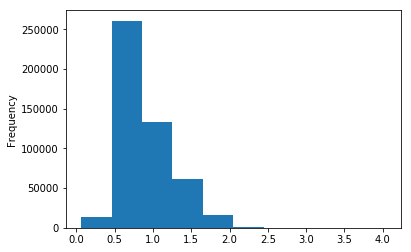

In [13]:
train['ps_reg_03'].plot(kind='hist')

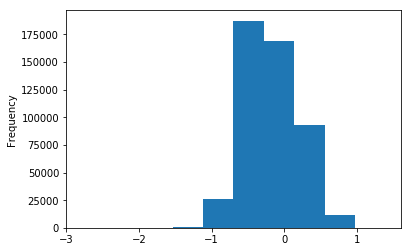

In [16]:
train['log_ps_reg_03'] = train['ps_reg_03'].map(np.log)
train['log_ps_reg_03'].plot(kind='hist')

In [ ]:
train = pd.read_csv('D:/Driver/train.csv')


In [2]:
avg = pd.read_csv('avg.csv')
cat = pd.read_csv('cat_submit.csv')
avg['cat'] = cat['target']

In [3]:
avg.head()

,id,target,xgb,lgb,0.75xgb+0.25lgb,0.25xgb+0.75lgb,0.5xgb+0.5lgb,cat
0,0,0,0.027262,0.027969,0.027439,0.027792,0.027615,0.025863
1,1,0,0.023622,0.025589,0.024114,0.025097,0.024605,0.027111
2,2,0,0.023600,0.025659,0.024115,0.025145,0.024630,0.024260
3,3,0,0.015024,0.015382,0.015114,0.015292,0.015203,0.014383
4,4,0,0.037317,0.036267,0.037055,0.036529,0.036792,0.034117


In [4]:
avg['xgb+cat'] = (avg['xgb']+avg['cat']) / 2.
avg['lgb+cat'] = (avg['lgb']+avg['cat']) / 2.

In [5]:
print pearsonr(avg['xgb'], avg['lgb'])
print pearsonr(avg['cat'], avg['lgb'])
print pearsonr(avg['xgb'], avg['cat'])
print pearsonr(avg['0.75xgb+0.25lgb'], avg['lgb'])
print pearsonr(avg['0.75xgb+0.25lgb'], avg['xgb+cat'])
print pearsonr(avg['0.75xgb+0.25lgb'], avg['lgb+cat'])

(0.97888554066601985, 0.0)
(0.9587651009263074, 0.0)
(0.96491594872705344, 0.0)
(0.98779965208571607, 0.0)
(0.99195455281911404, 0.0)
(0.98763145945082842, 0.0)


In [7]:
vals = avg[['xgb', 'lgb', 'cat']].values
print hmean(vals,axis=1)

[ 0.0270026   0.02535959  0.02447697 ...,  0.03729915  0.02352689
  0.03028226]


In [8]:
avg['hmean'] = hmean(vals, axis=1)
avg.head()

,id,target,xgb,lgb,0.75xgb+0.25lgb,0.25xgb+0.75lgb,0.5xgb+0.5lgb,cat,xgb+cat,lgb+cat,hmean
0,0,0,0.027262,0.027969,0.027439,0.027792,0.027615,0.025863,0.026562,0.026916,0.027003
1,1,0,0.023622,0.025589,0.024114,0.025097,0.024605,0.027111,0.025367,0.026350,0.025360
2,2,0,0.023600,0.025659,0.024115,0.025145,0.024630,0.024260,0.023930,0.024960,0.024477
3,3,0,0.015024,0.015382,0.015114,0.015292,0.015203,0.014383,0.014704,0.014882,0.014918
4,4,0,0.037317,0.036267,0.037055,0.036529,0.036792,0.034117,0.035717,0.035192,0.035850


In [12]:
avg['xgb+lgb+cat'] = (avg['lgb'] + avg['xgb'] + avg['cat']) / 3.
avg.head()

,id,target,xgb,lgb,0.75xgb+0.25lgb,0.25xgb+0.75lgb,0.5xgb+0.5lgb,cat,xgb+cat,lgb+cat,hmean,xgb+lgb+cat
0,0,0,0.027262,0.027969,0.027439,0.027792,0.027615,0.025863,0.026562,0.026916,0.027003,0.027031
1,1,0,0.023622,0.025589,0.024114,0.025097,0.024605,0.027111,0.025367,0.026350,0.025360,0.025441
2,2,0,0.023600,0.025659,0.024115,0.025145,0.024630,0.024260,0.023930,0.024960,0.024477,0.024507
3,3,0,0.015024,0.015382,0.015114,0.015292,0.015203,0.014383,0.014704,0.014882,0.014918,0.014930
4,4,0,0.037317,0.036267,0.037055,0.036529,0.036792,0.034117,0.035717,0.035192,0.035850,0.035900


In [13]:
print pearsonr(avg['hmean'], avg['xgb+lgb+cat'])

(0.99968153575415708, 0.0)


In [9]:
res = avg[['id', 'hmean']]
res.columns = ['id', 'target']
res.head()

,id,target
0,0,0.027003
1,1,0.025360
2,2,0.024477
3,3,0.014918
4,4,0.035850


In [10]:
res.to_csv('hmean.csv', index=False)